In [38]:
#imports


from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import math as m
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel


%matplotlib inline

#function to read from fits file
def readdata(s):

  
  with fits.open(s) as hdul:
    mydata = np.array(hdul[1].data)
    sz = mydata.size
    data1 = np.zeros(sz)
    data2 = np.zeros(sz)
    data3 = np.zeros(sz)
    for i in range(sz):
        data1[i] = mydata[i][0]
        data2[i] = mydata[i][1]
        data3[i] = mydata[i][1]
    return data1,data2,data3



#function for binning
def resolution(r, arr):
    arr2 = np.zeros(len(arr)//r)
    for i in range(len(arr)//r):
        sum = 0
        for j in range(r):
            sum += arr[r*i + j]
        sum/= r
        arr2[i] = sum
    return arr2

#smoothening
def smoothen(arr):
    smoothed_signal = convolve(arr, Box1DKernel(5))
    return smoothed_signal

'''
    for i in range(2, len(arr)-3):
        arr[i] = (arr[i-2] + arr[i-1] + arr[i] + arr[i+1] + arr[i+2])/5
    return arr
'''

def process_marks(marks_list, peak_times): #takes the list of flares with redundancies and removes them. 
    #Finds accurate start and end times based on increasing decreasing logic
    
    final_m = []
    for i in peak_times:
        time_min = []
        time_max = []
        for j in marks_list:
            if j[1] == i:
                time_min.append(min(j[0], j[2]))
                time_max.append(max(j[0], j[2]))
        final_m.append([min(time_min), i, max(time_max)])
    
    return final_m





def prepare_data(s): #reads data, bins and smoothens it and returns a list of 2 arrays, one containing times and the other intensities
    dat = list(readdata(s))
    dat[0] = dat[0] - dat[0][0]
    sz = len(dat[0])
    #dat[1] = smoothen(dat[1])
    #dat[1] = smoothen(dat[1])
    dat[0] = resolution(120,dat[0])
    dat[1] = resolution(120,dat[1])
    dat[1] = smoothen(dat[1])
    return dat


def display_data(dat): #main function that displays the data and any peaks in it

    dat2 = [np.zeros(len(dat[0])), np.zeros(len(dat[0]))] 
    mean, median, std, max_val = analyse_data(dat[1]) #get some details of the distribution
    dat2[0] = dat[0]
    dat2[1] = np.where(dat[1]<30, dat[1], 30) #dat2 is created to work with small flares in the prescence of big ones
    
    flares_i, flares_t, flare_marks = find_flares(dat[1],dat[0])#finds the coordinates of flare peaks
    
    flare_marks = process_marks(flare_marks, flares_t)
            
    
    plt.figure(figsize = (18,10))
    plt.xlabel('time')
    plt.ylabel('intensity')
    
    #code to separate the flare markings into the 2 graphs we will use for the plotting
    flares_t1 = []
    flares_t2 = []
    midpoint = dat[0][len(dat[0])//2]
    for i in flares_t:
        if i < midpoint:
            flares_t1.append(i)
        else:
            flares_t2.append(i)
    flares_i1 = flares_i[:len(flares_t1)]
    flares_i2 = flares_i[len(flares_t1):]
    
    #plotting
    p1 = plt.subplot(2,1,1)
#    p1.set_ylim(0,100)
    p1.plot(dat[0][:len(dat[0])//2],dat[1][:len(dat[0])//2], color = 'red')
    p1.scatter(flares_t1,flares_i1)
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')
    p2 = plt.subplot(2,1,2)
#    p2.set_ylim(0,100)
    p2.plot(dat[0][len(dat[0])//2:],dat[1][len(dat[0])//2:], color = 'red')
    p2.scatter(flares_t2,flares_i2)
    plt.xlabel('time')
    plt.ylabel('intensity')

    plt.show()
    return flare_marks, dat[0], dat[1] #return the light data as well as the preliminary flare start, end data 
#without implementing background
    #plotting of small flares n prescence of big flares as well
    '''
    if max_val > 30:    
        plt.figure(figsize = (18,10))
        plt.xlabel('time')
        plt.ylabel('intensity')


        p1 = plt.subplot(2,1,1)
    #    p1.set_ylim(0,100)
        p1.plot(dat2[0][:len(dat[0])//2],dat2[1][:len(dat2[0])//2])
        plt.title(s)
        plt.xlabel('time')
        plt.ylabel('intensity')
        p2 = plt.subplot(2,1,2)
    #    p2.set_ylim(0,100)
        p2.plot(dat[0][len(dat2[0])//2:],dat2[1][len(dat2[0])//2:])
        plt.xlabel('time')
        plt.ylabel('intensity')
        plt.show()
    '''
    #print(flares_t)
    
def plot_flares(dat): #meant for plotting data, pass time and intensity arrays in one list dat
    p1 = plt.subplot(2,1,1)
#    p1.set_ylim(0,100)
    p1.plot(dat[0][:len(dat[0])//2],dat[1][:len(dat[0])//2], color = 'red')
    plt.title(s)
    plt.xlabel('time')
    plt.ylabel('intensity')
    p2 = plt.subplot(2,1,2)
#    p2.set_ylim(0,100)
    p2.plot(dat[0][len(dat[0])//2:],dat[1][len(dat[0])//2:], color = 'red')
    plt.xlabel('time')
    plt.ylabel('intensity')

    #plt.show()

def analyse_data(arr):  #returns some standard info about the distribution and prints it out as well
    mean = np.mean(arr)
    std = np.std(arr)
    print('mean', mean)
    print('std', std)
    median = np.median(arr)
    print('median', median)
    max_val = np.max(arr)
    print('max', max_val)
    increment = max_val - median
    print('increment', increment)
    return mean,median,std,max_val


def first_element(t):
    return t[0]

def find_flares(arr_f, times): #finds flare peaks
    flares_t = []
    flares_i = []
    flare_marks = []
    flare_peaks = []
    
    #forward search
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.03*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i], times[i+3+m], times[j+2])) #allows for redundancy but gives proper start and end times
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    #reverse and search again, look for peaks that havent already been found
    arr_f = arr_f[::-1]
    times = times[::-1]
    for i in range(len(arr_f)-3):
        if arr_f[i+3] > arr_f[i+2] > arr_f[i+1] > arr_f[i]:
            if arr_f[i+3] > 1.08*arr_f[i]:
                for j in range(i+3,len(arr_f)-2):
                    if arr_f[j] > arr_f[j+1] > arr_f[j+2]:
                        m = np.argmax(arr_f[i+3:j+1])
                        if times[i+3+m] not in flares_t:
                            flares_t.append(times[i+3+m])
                            flare_peaks.append((times[i+3+m],arr_f[i+3+m]))
                        flare_marks.append((times[i],times[i+3+m], times[j+2]))
                            #print('row', i, m, j, times[i], arr_f[i], arr_f[i+3], arr_f[i+3+m], arr_f[j],arr_f[j+1], arr_f[j+2], times[j+2])
                        break
    
    flare_peaks.sort(key = first_element)
    #print(flares)
    flares_t = []
    flares_i = []
    for i in flare_peaks:
        flares_i.append(i[1])
        flares_t.append(i[0])
    return flares_i,flares_t, flare_marks
    
#flare start and end times


def remove_flares(fl_marks, arr_t, arr_i): #removes data within fl_marks from intensity array
    #format of fl_marks is : list of [start time, peak time, end time]
    arr_i_sub = np.array(arr_i)
    arr_i2 = []
    arr_t2 = []
    for i in fl_marks:
        arr_i_sub[np.where(arr_t == i[0])[0][0]:np.where(arr_t == i[2])[0][0]] = 0
    
    for i in range(len(arr_i_sub)):
        if arr_i_sub[i] !=0:
            arr_i2.append(arr_i_sub[i])
            arr_t2.append(arr_t[i])
    return arr_i2, arr_t2

def shrink_std(arr): #shrinks std range by rejecting data outside 1 std
    arr2 = []
    mean = np.mean(arr)
    std = np.std(arr)
    for i in arr:
        if i > mean-std and i <mean+std:
            arr2.append(i)
    return arr2





mean 36.763274745631236
std 30.851536839787233
median 26.521220266024272
max 192.95617960611983
increment 166.43495934009556


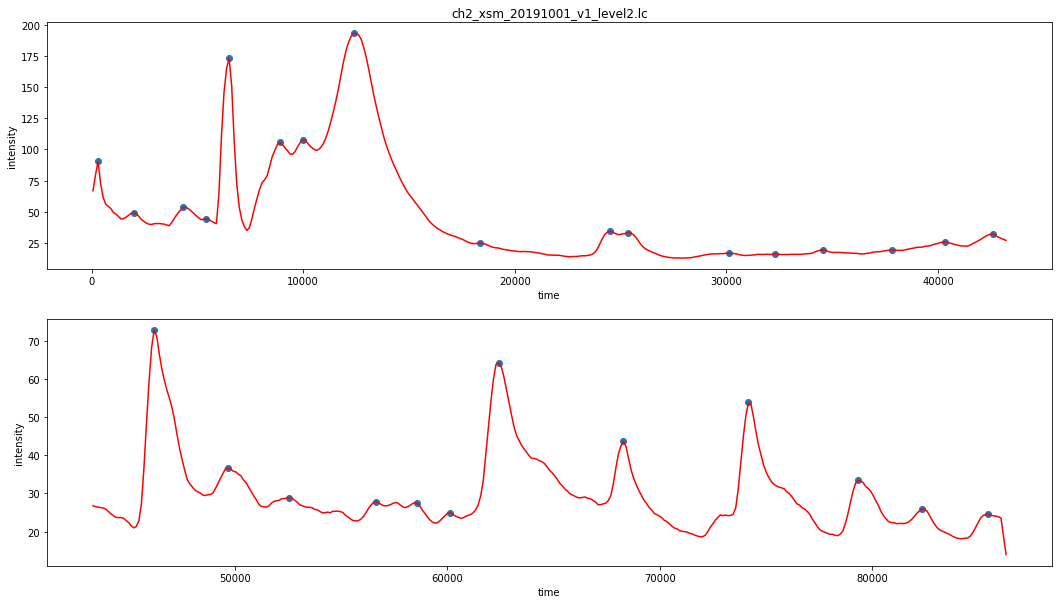

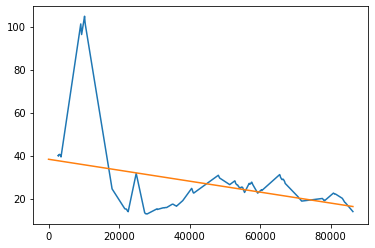

29


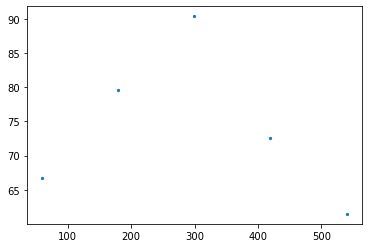

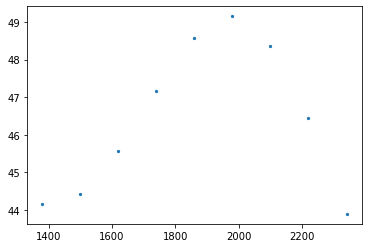

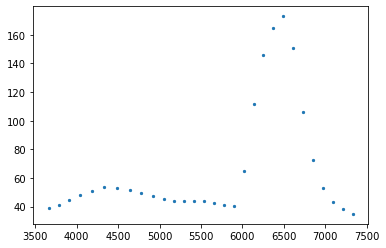

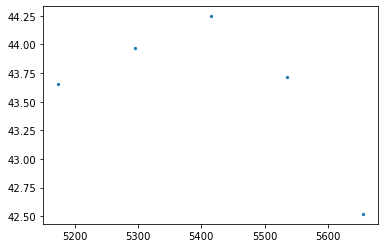

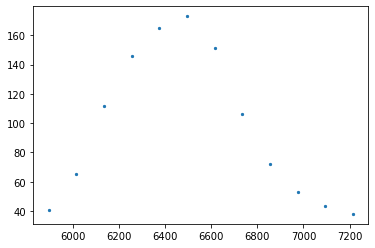

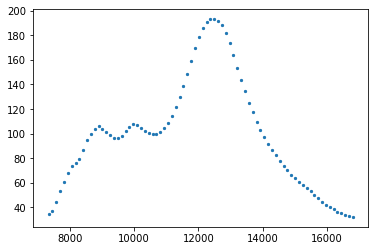

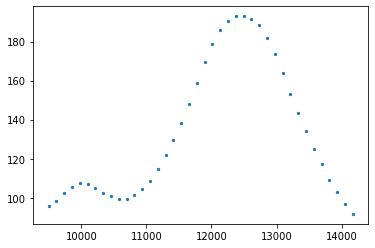

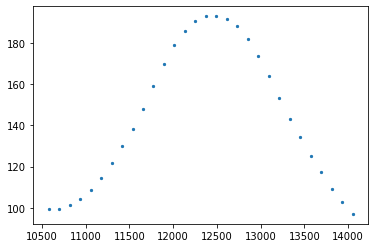

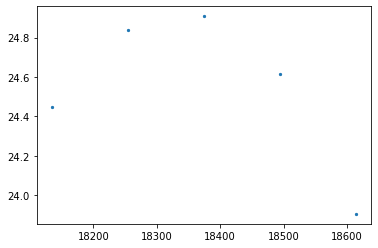

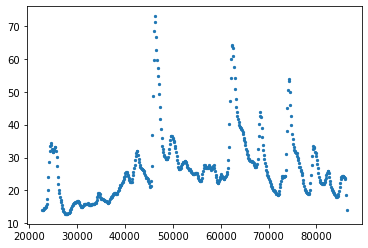

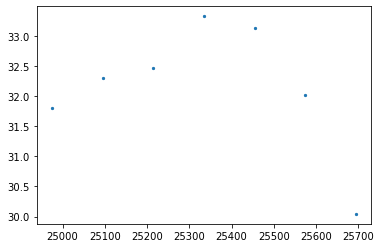

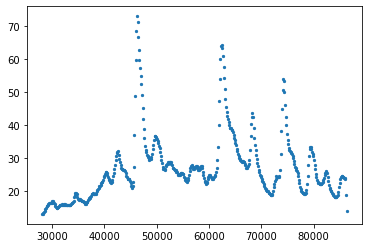

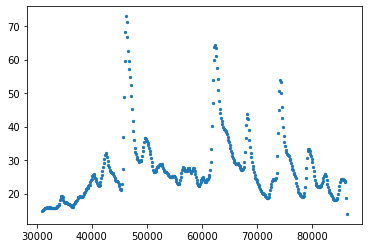

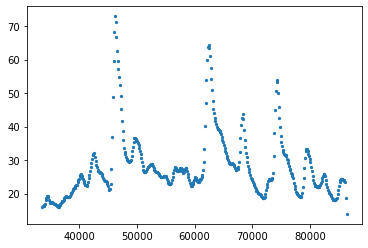

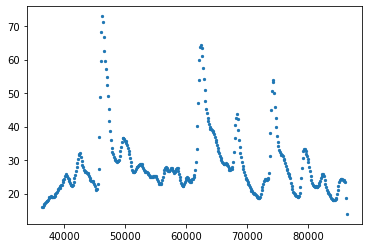

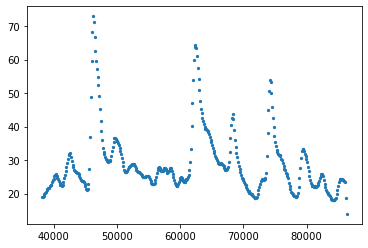

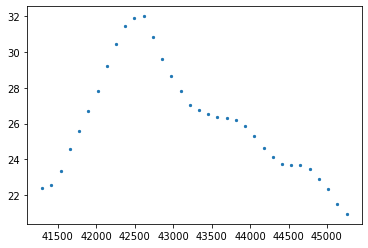

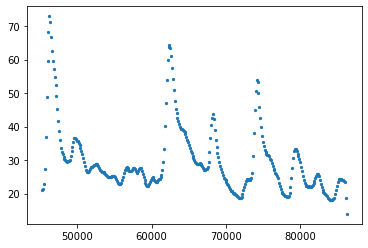

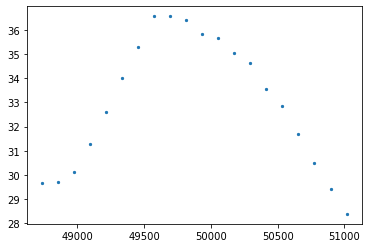

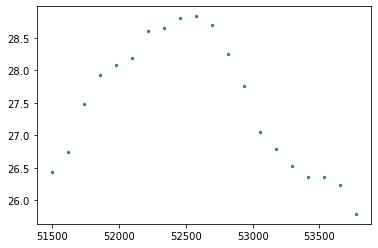

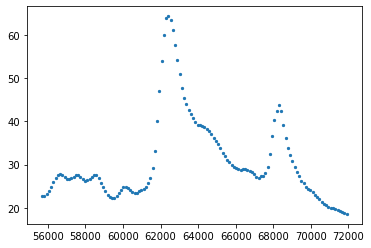

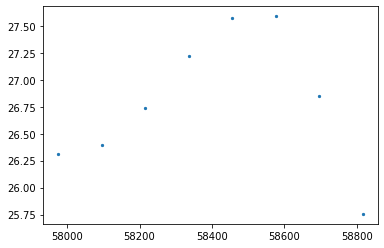

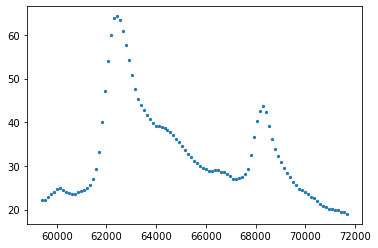

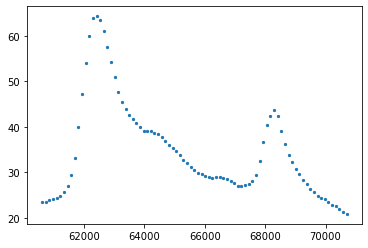

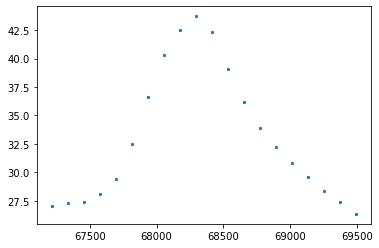

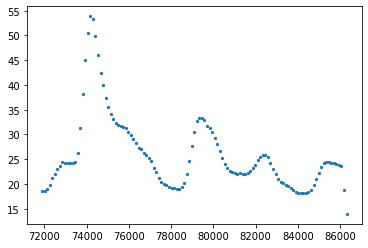

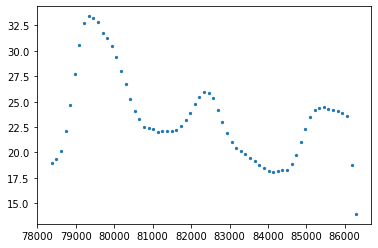

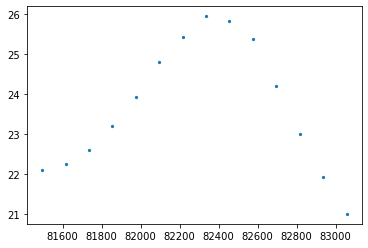

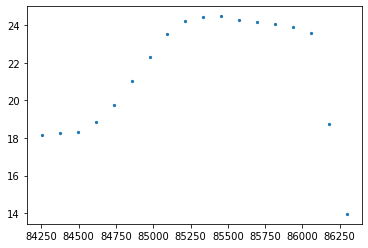

29
mean 19.29081066461133
std 7.465648605683834
median 17.885498312314354
max 85.04723176956178
increment 67.16173345724742


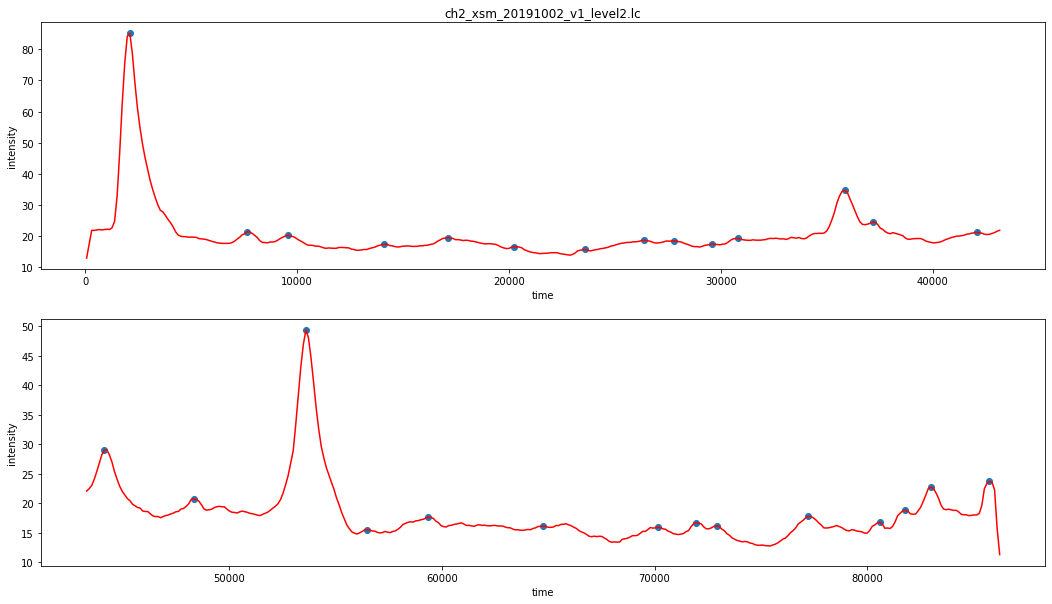

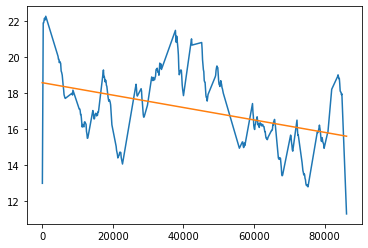

28


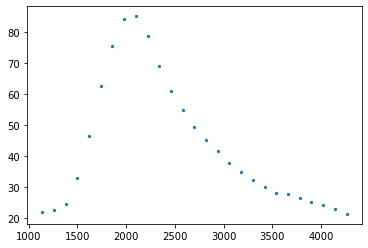

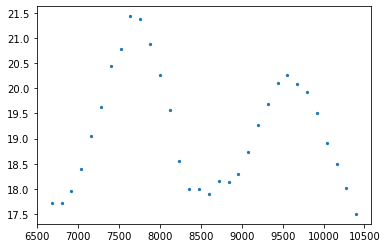

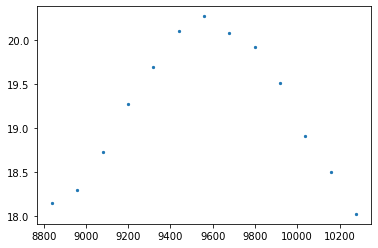

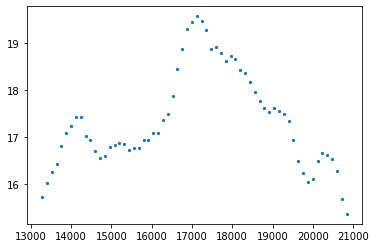

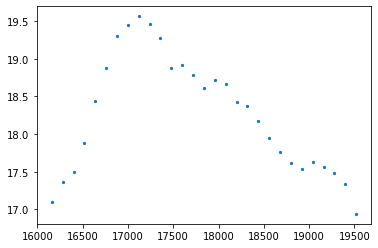

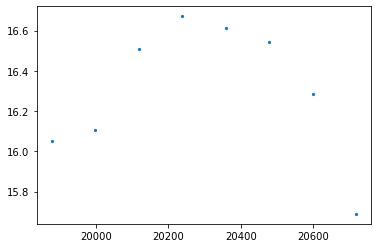

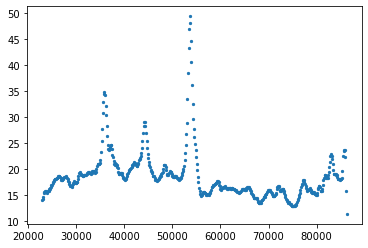

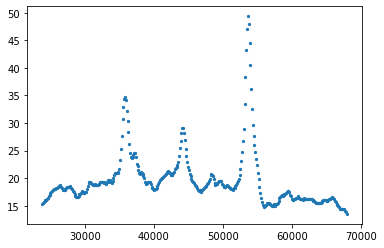

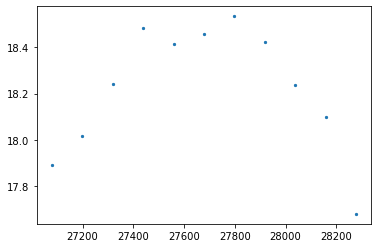

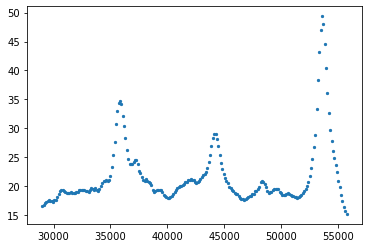

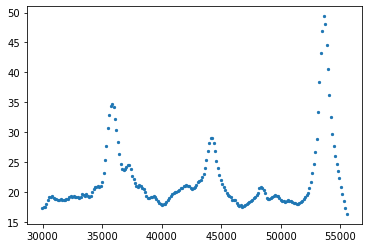

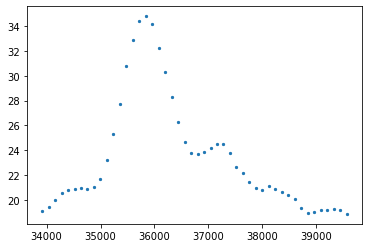

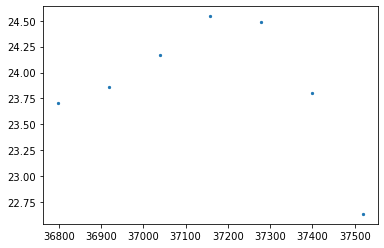

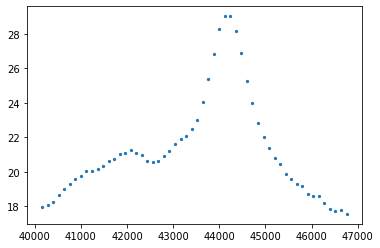

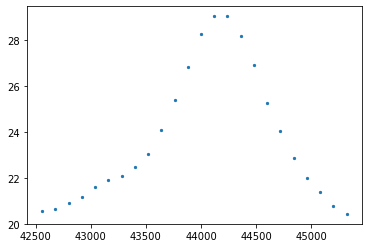

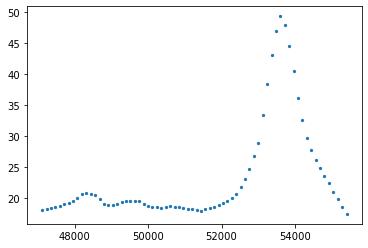

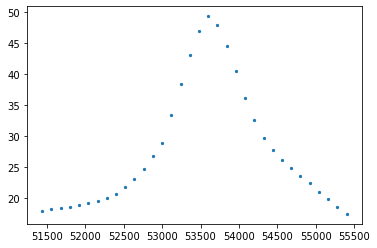

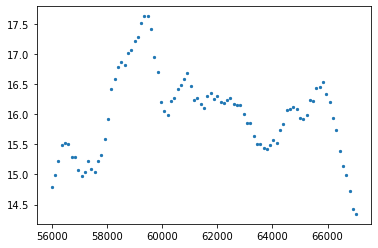

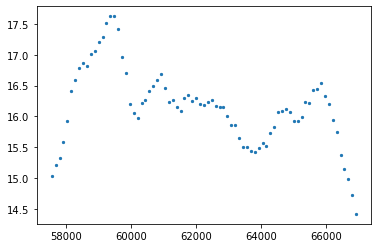

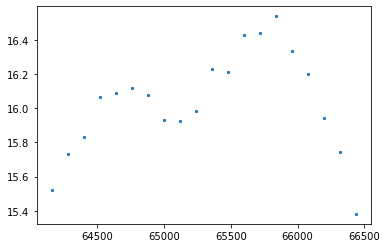

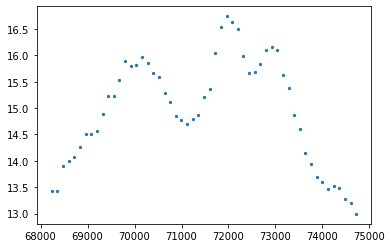

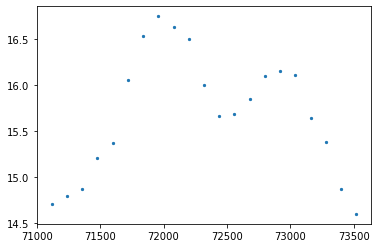

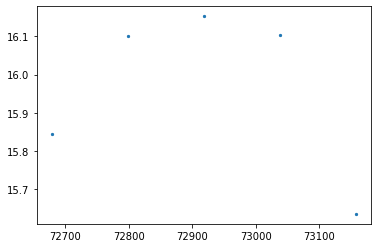

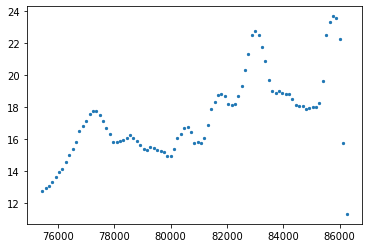

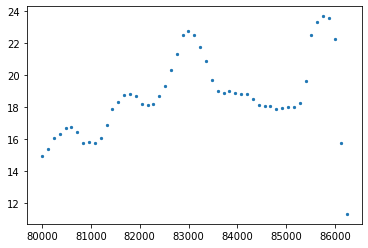

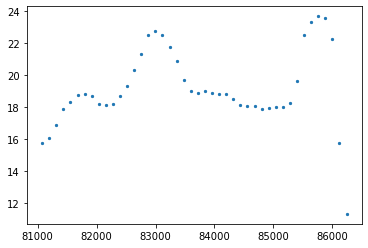

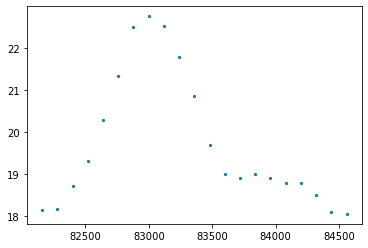

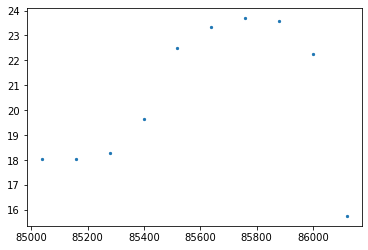

28
mean 12.325699595751509
std 1.7475977958364788
median 12.050838570992152
max 18.630091903209685
increment 6.579253332217533


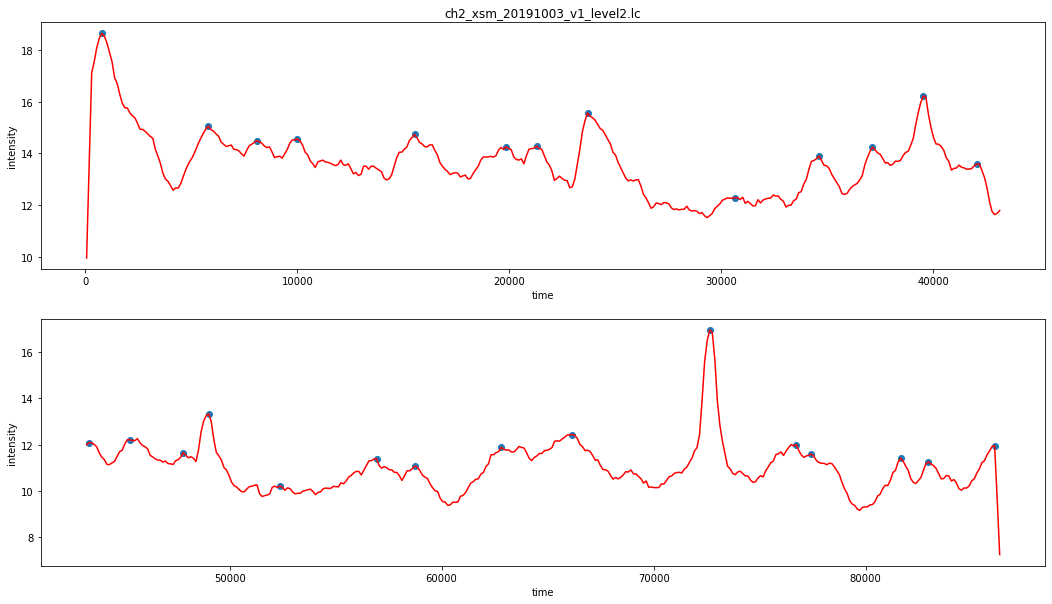

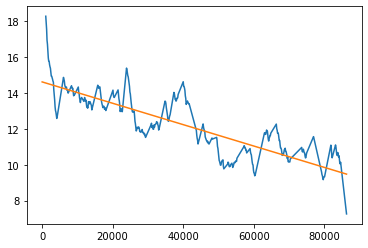

28


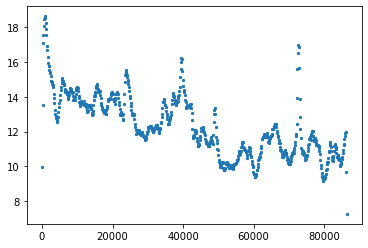

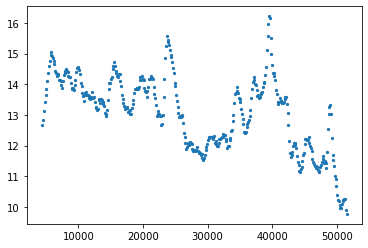

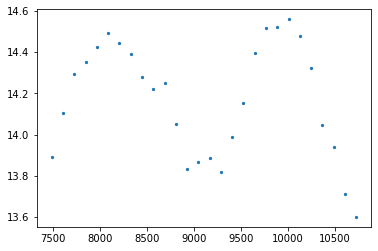

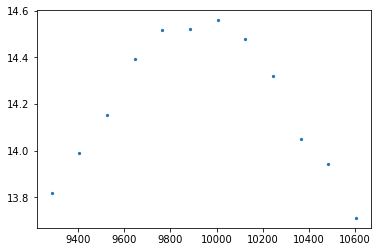

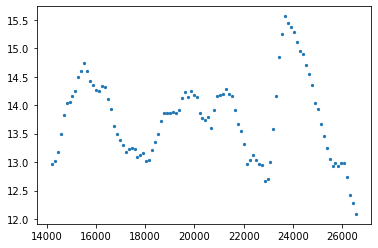

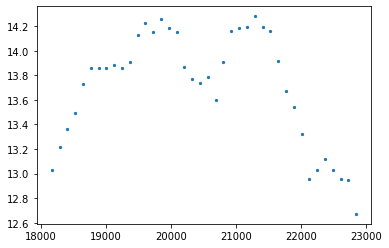

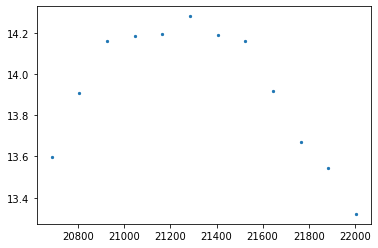

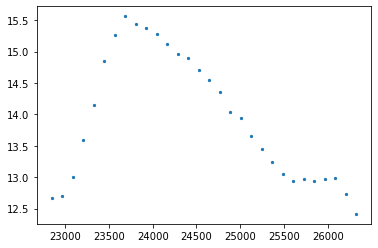

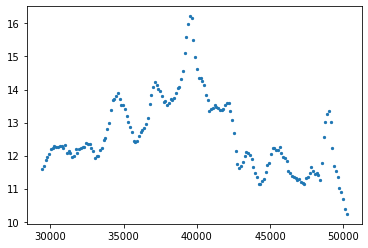

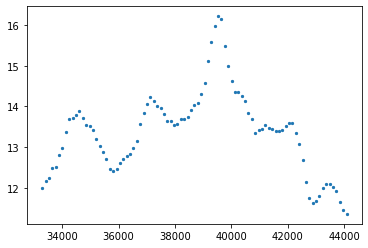

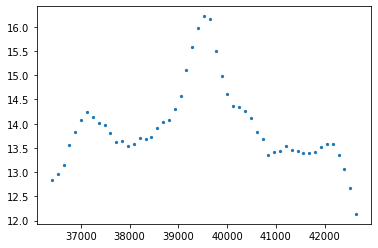

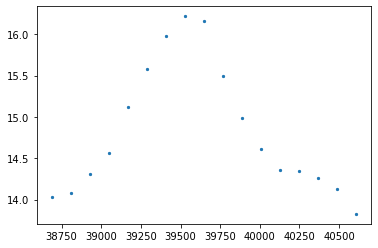

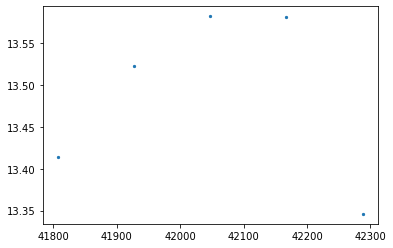

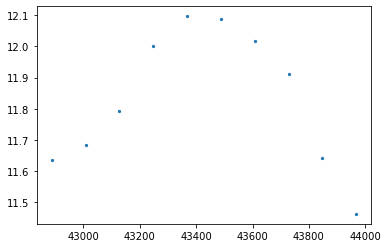

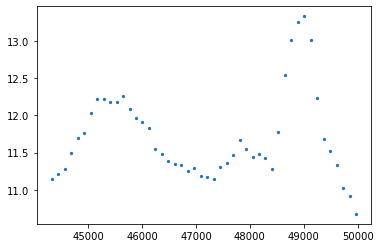

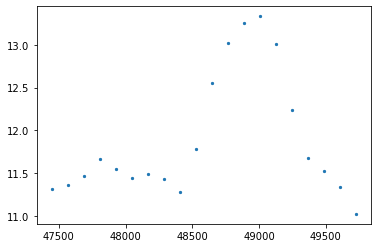

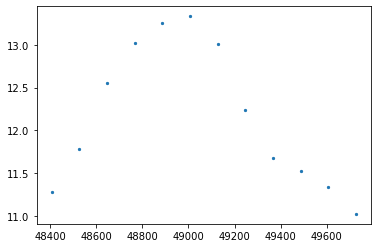

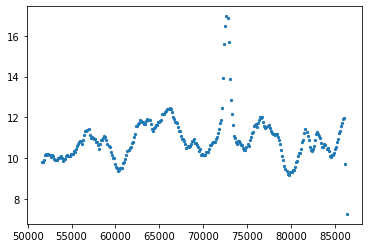

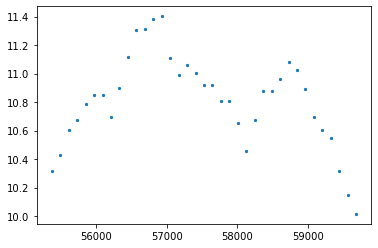

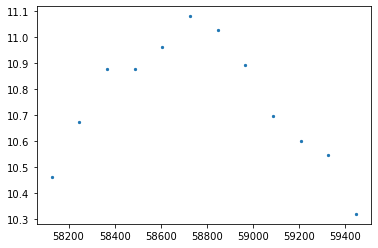

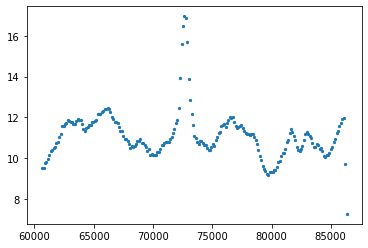

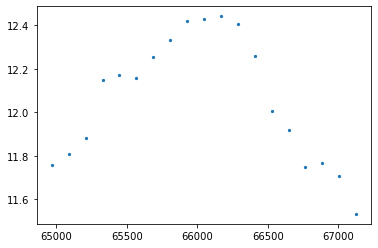

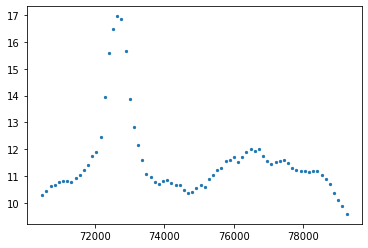

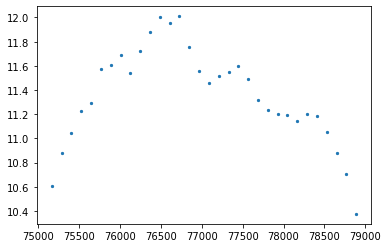

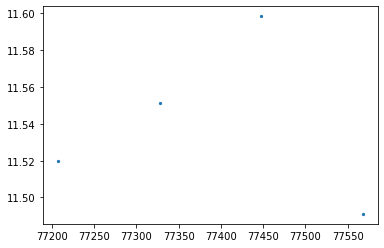

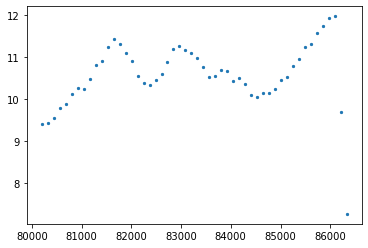

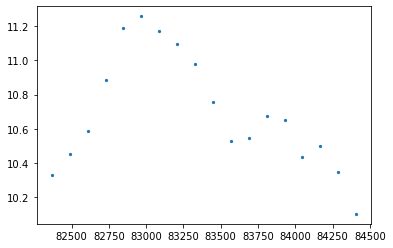

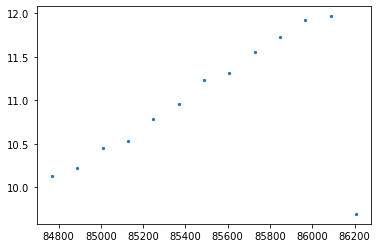

28
mean 12.452259069622652
std 7.424002020989014
median 10.79388210018476
max 79.82460421244303
increment 69.03072211225827


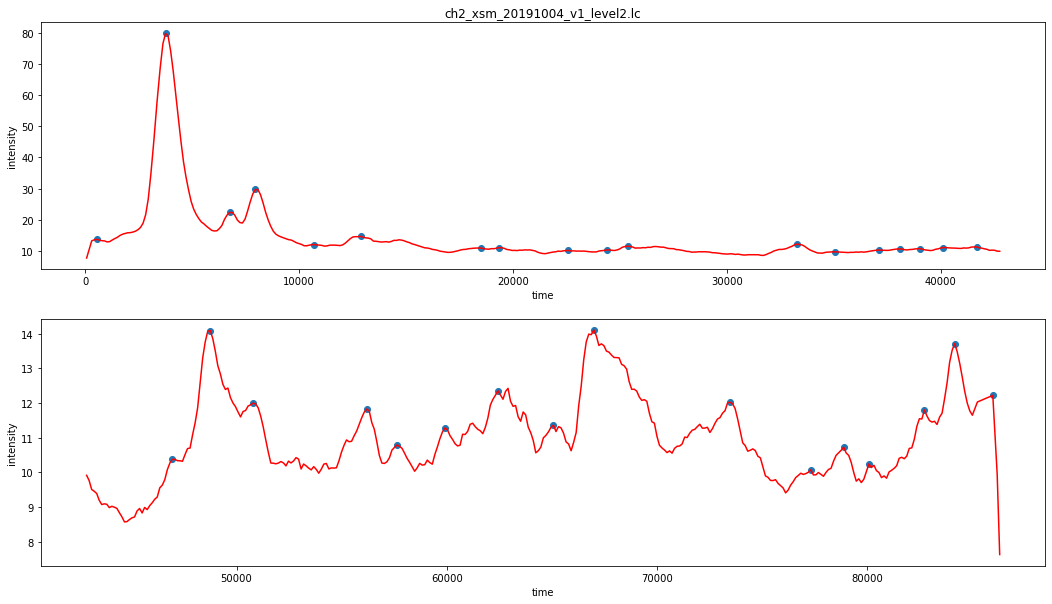

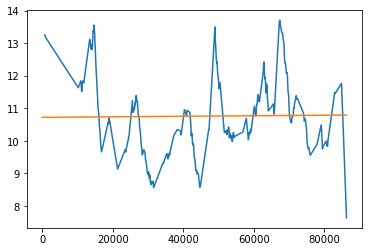

34


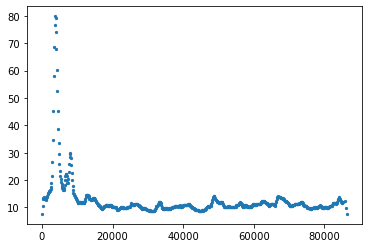

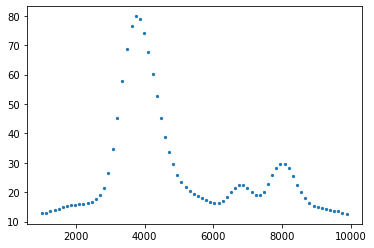

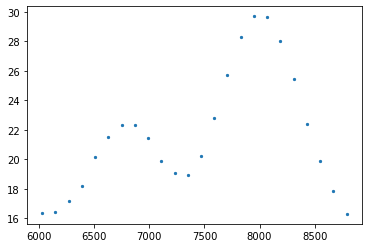

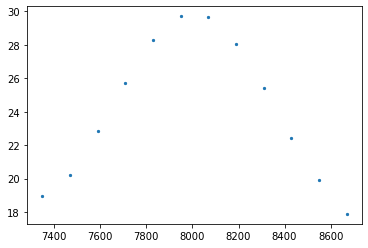

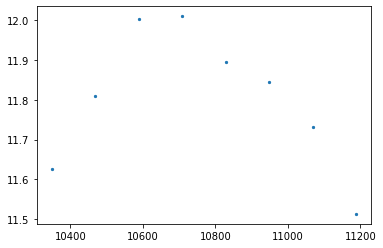

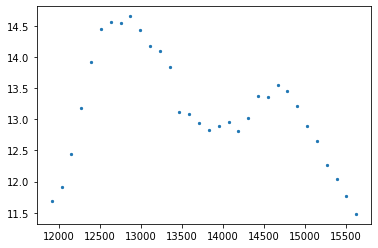

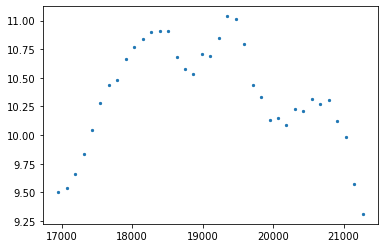

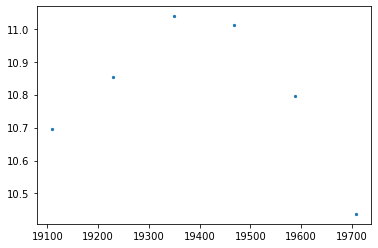

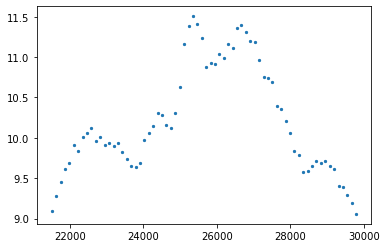

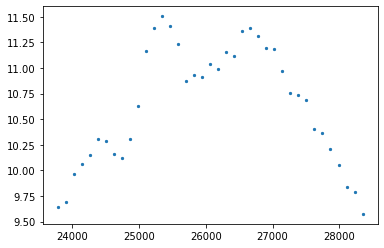

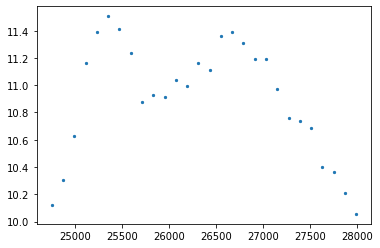

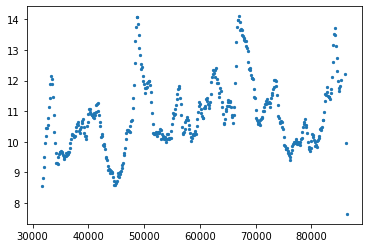

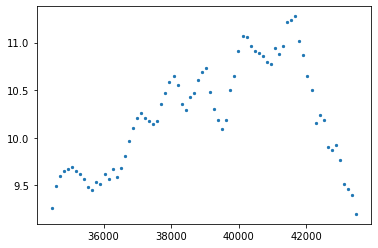

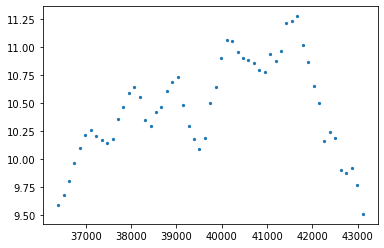

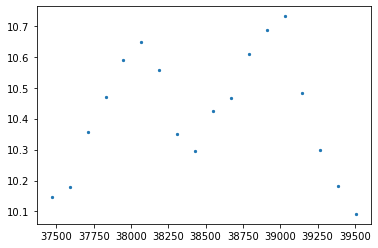

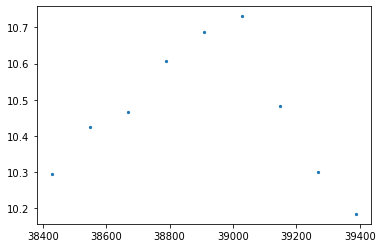

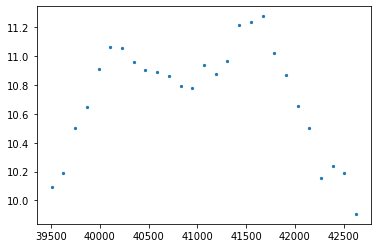

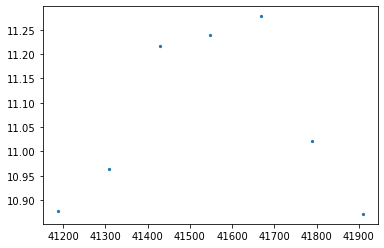

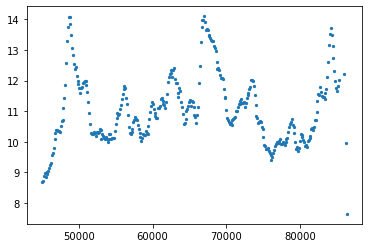

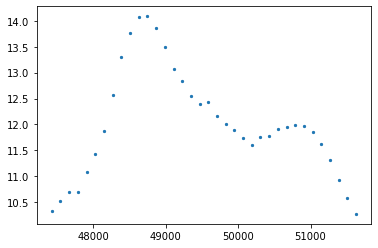

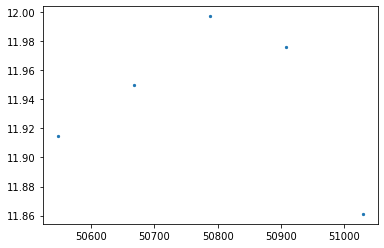

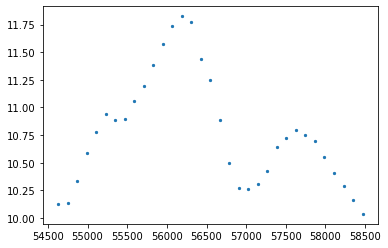

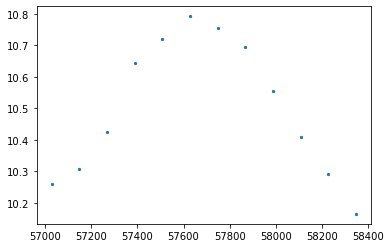

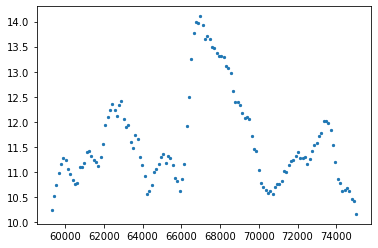

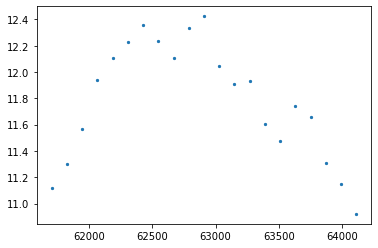

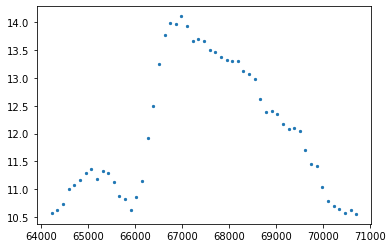

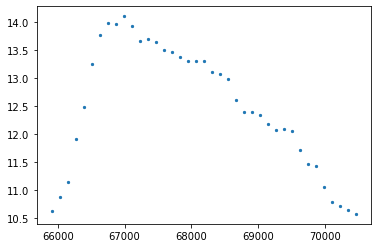

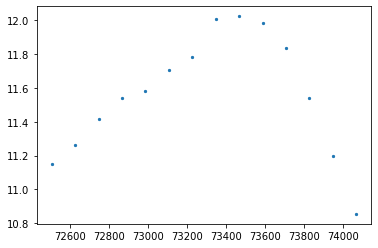

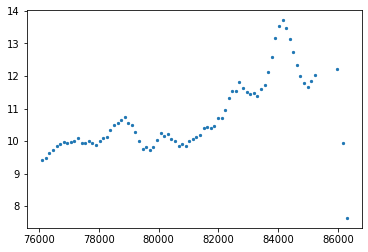

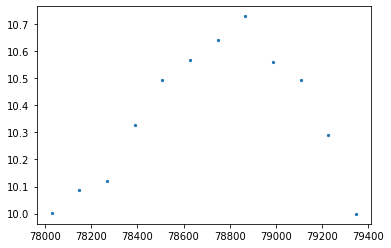

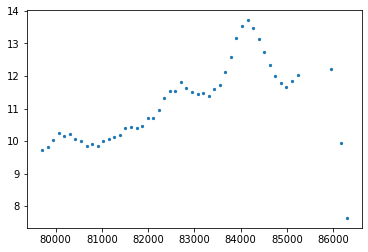

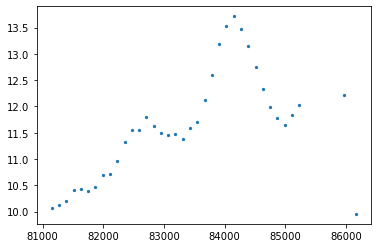

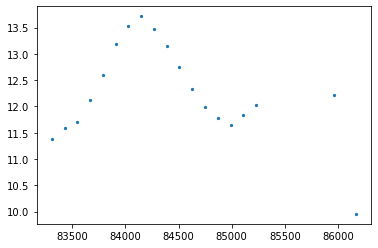

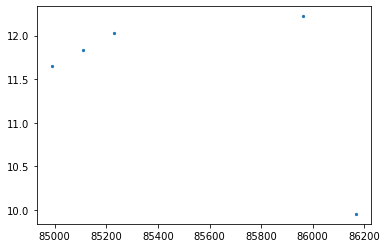

34
mean 10.155914810351435
std 1.9985306760740302
median 9.670719095468522
max 27.369442675113678
increment 17.698723579645154


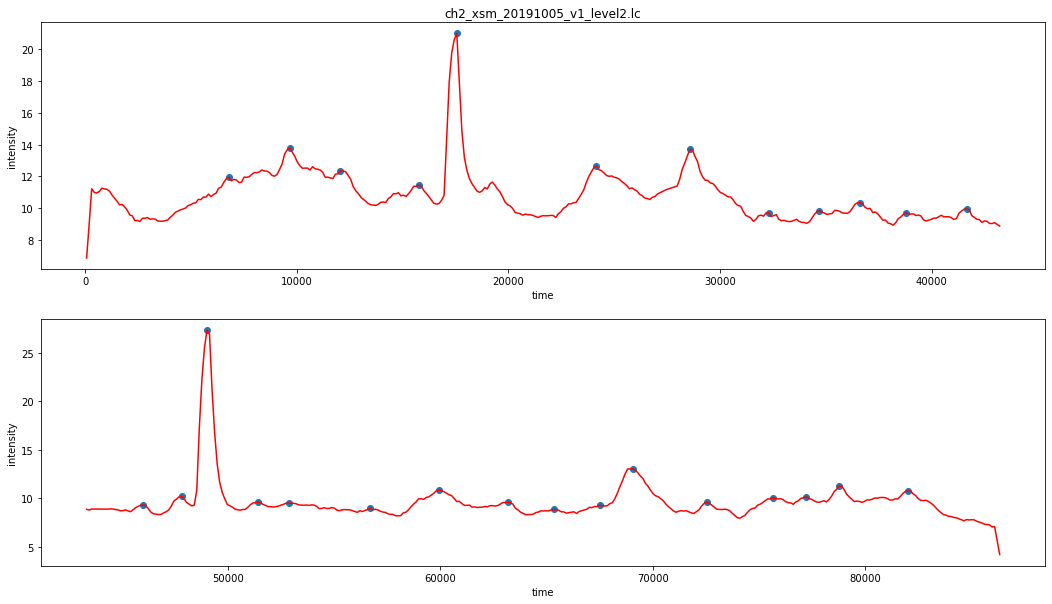

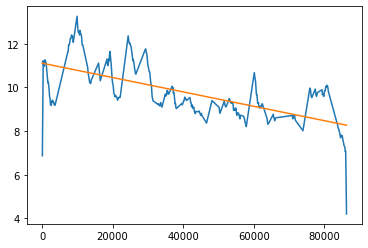

28


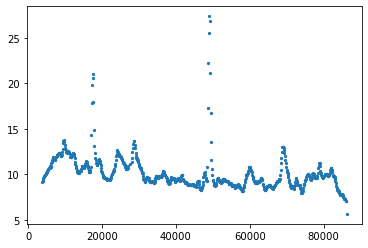

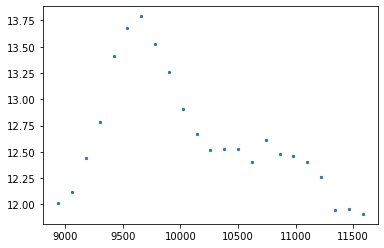

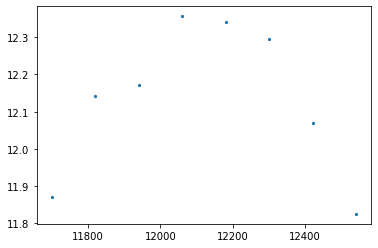

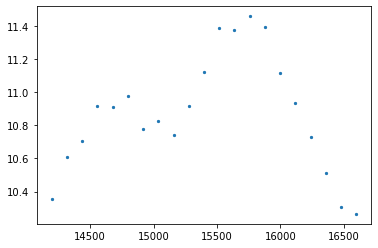

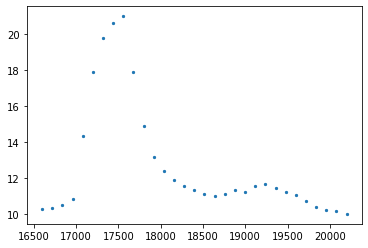

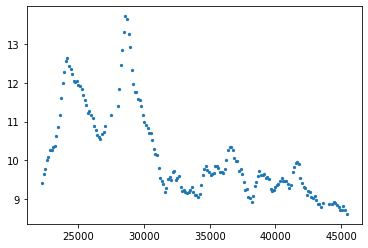

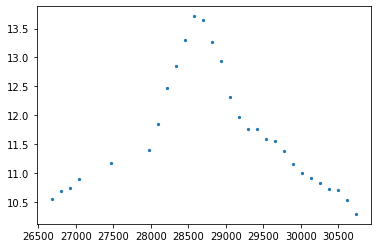

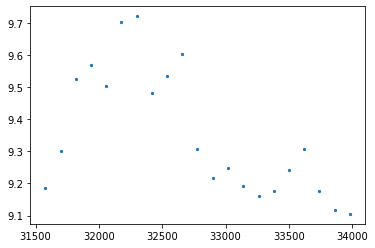

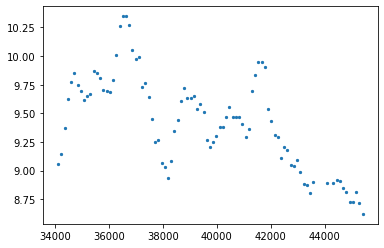

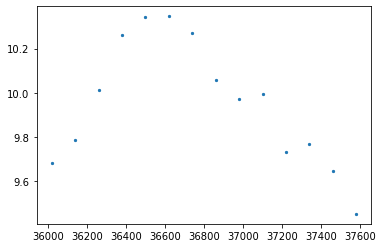

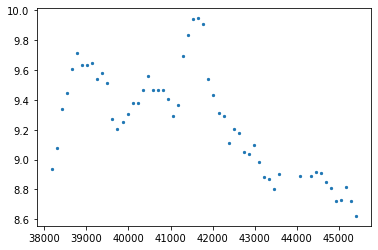

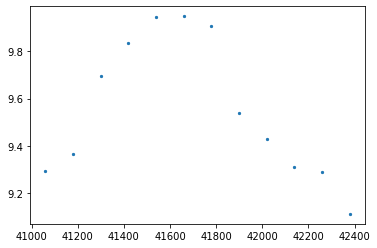

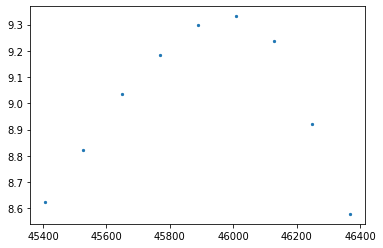

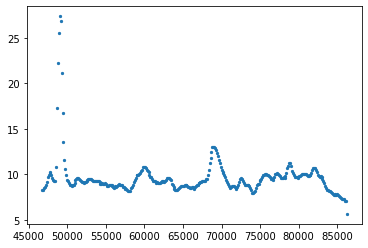

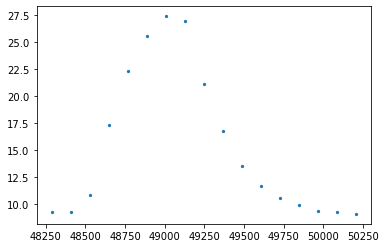

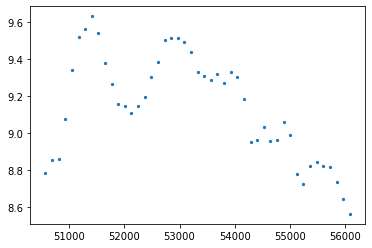

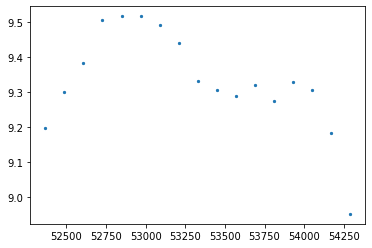

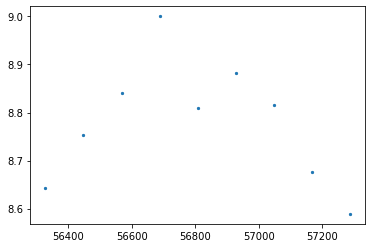

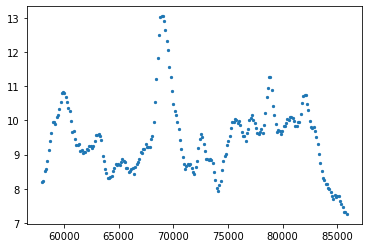

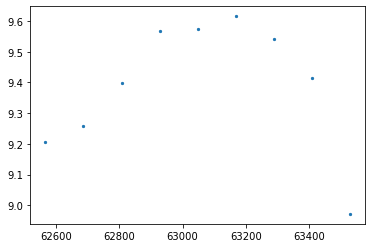

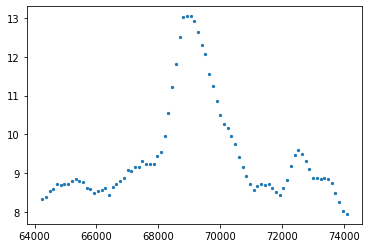

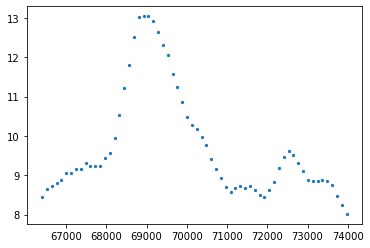

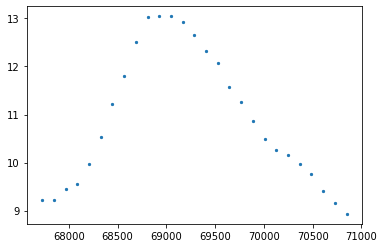

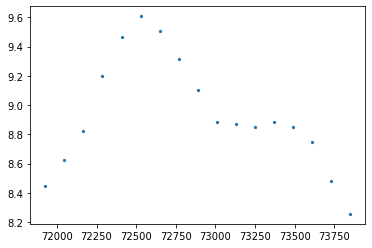

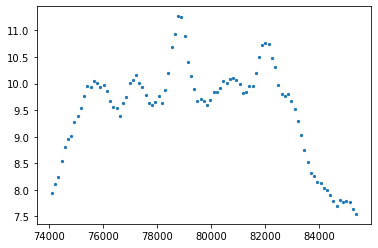

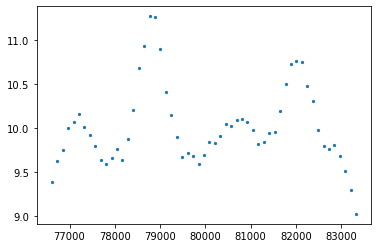

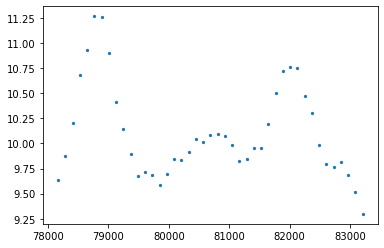

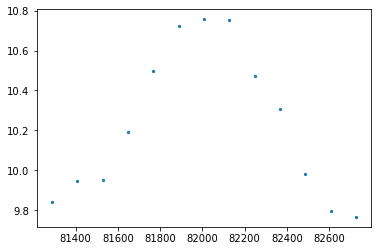

28
mean 6.579480086867434
std 0.8252692039342594
median 6.554394014080366
max 9.788295091589294
increment 3.2339010775089285


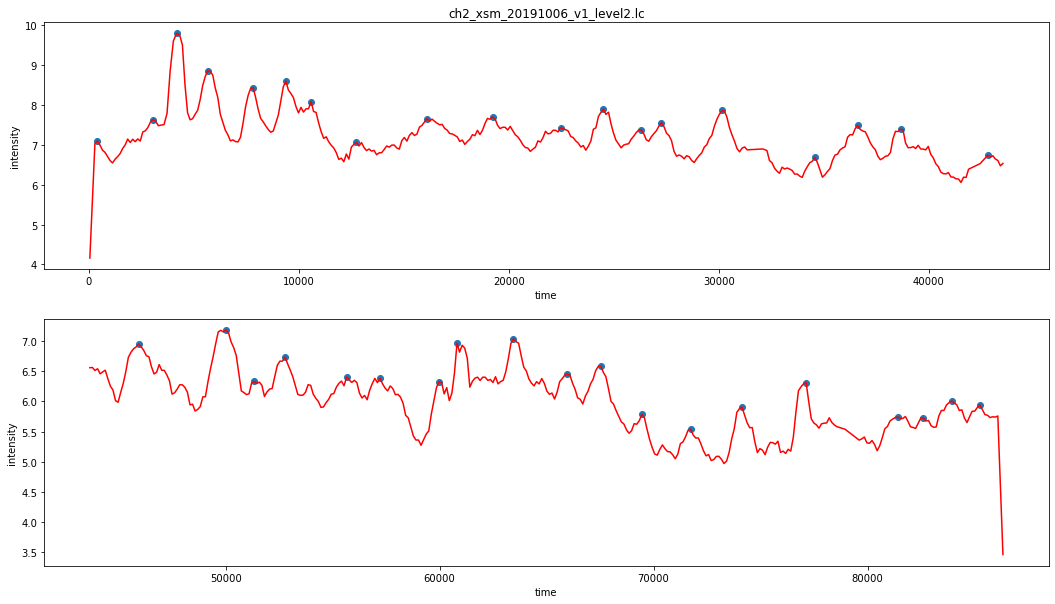

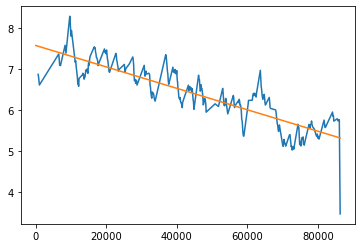

38


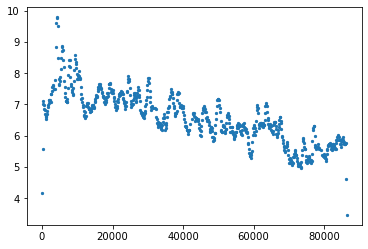

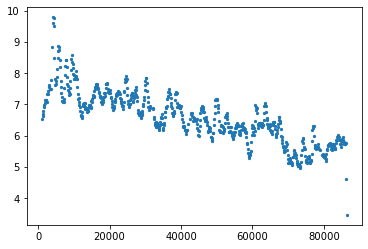

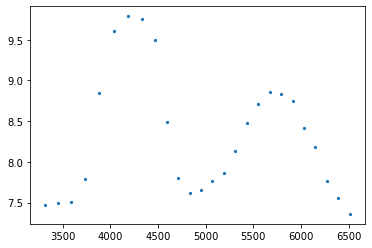

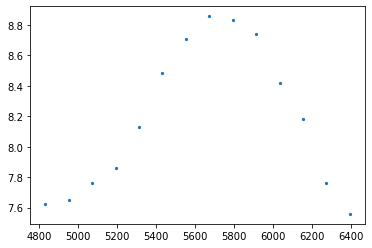

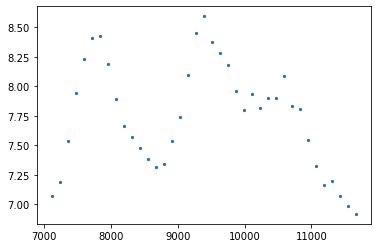

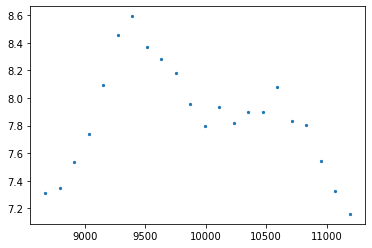

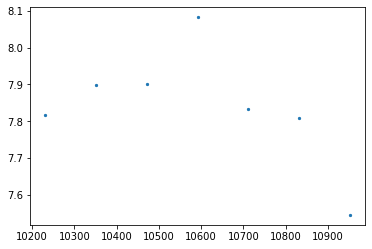

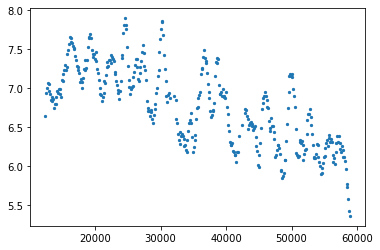

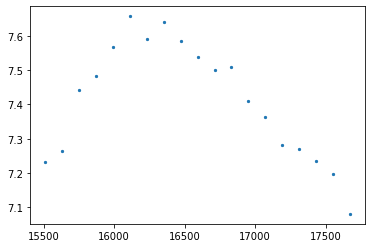

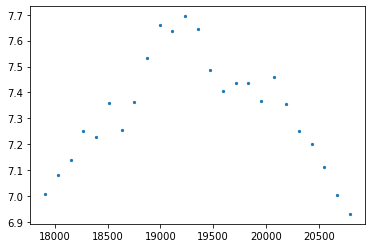

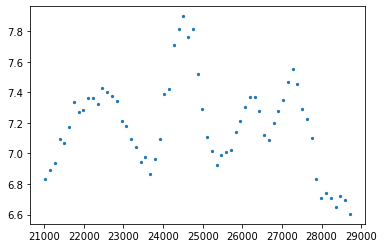

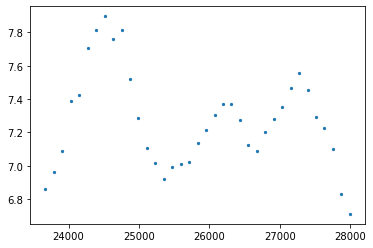

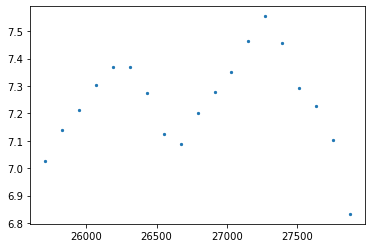

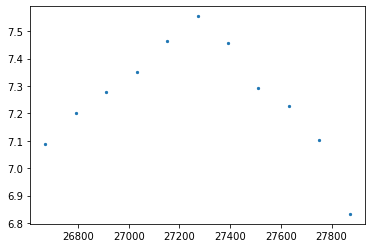

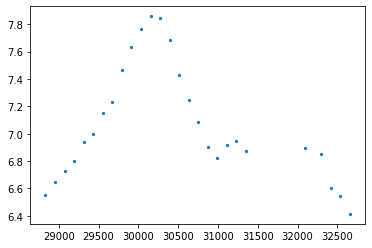

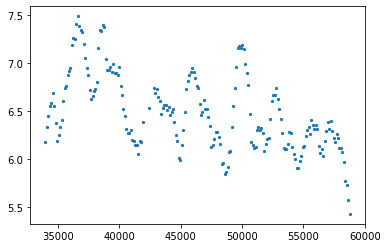

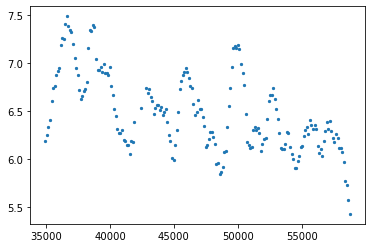

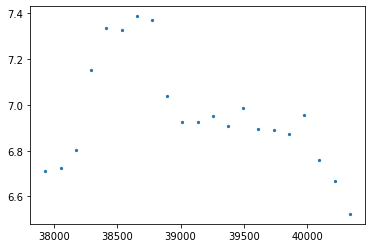

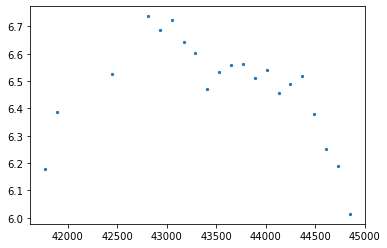

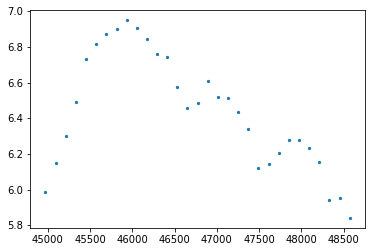

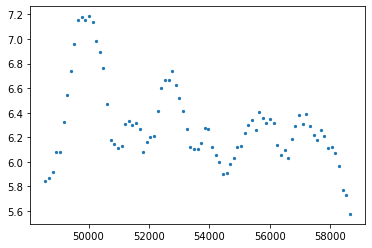

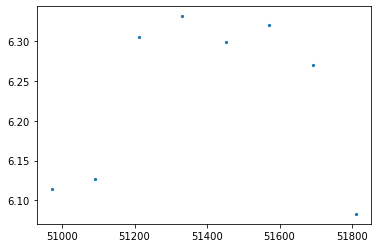

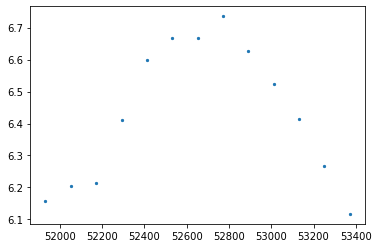

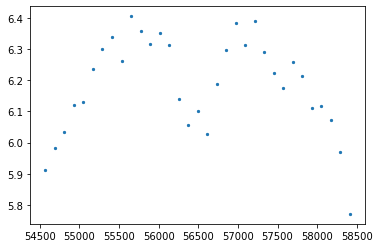

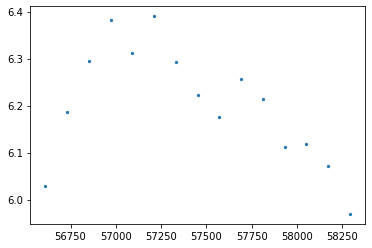

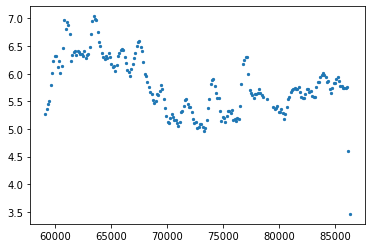

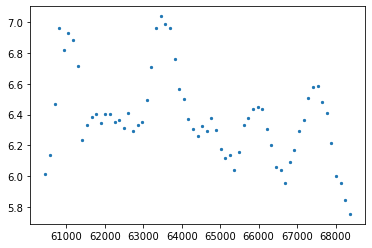

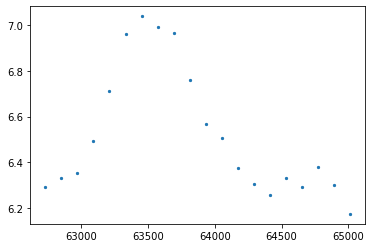

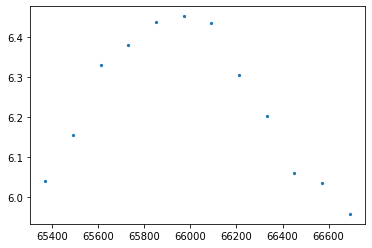

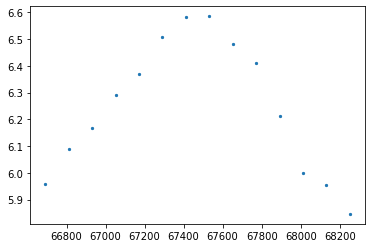

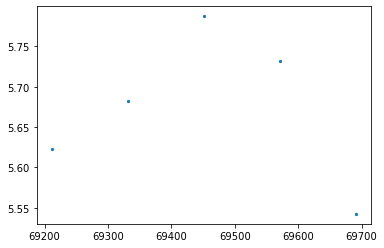

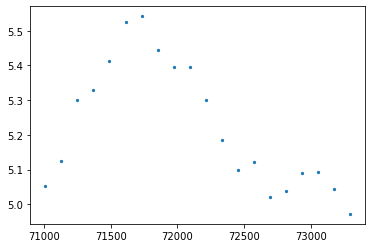

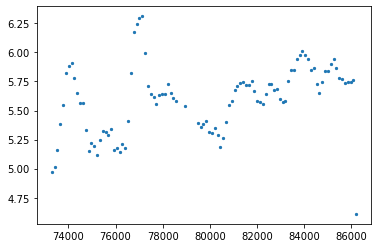

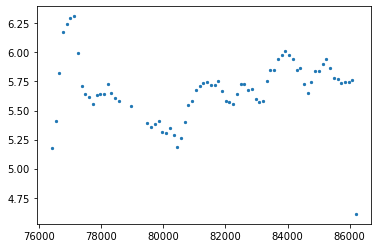

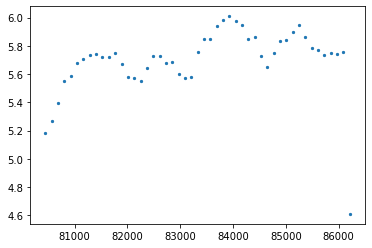

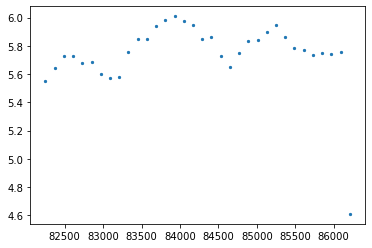

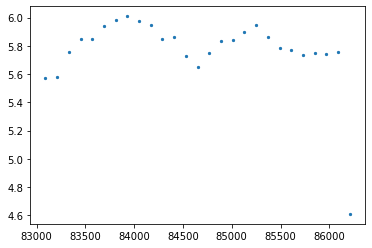

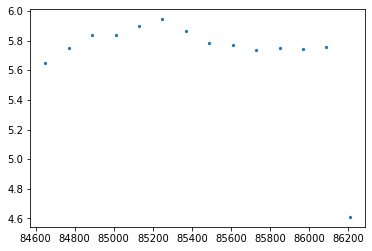

38
mean 5.793499864150035
std 0.3875406175974877
median 5.781739767789841
max 8.016018040776252
increment 2.234278272986412


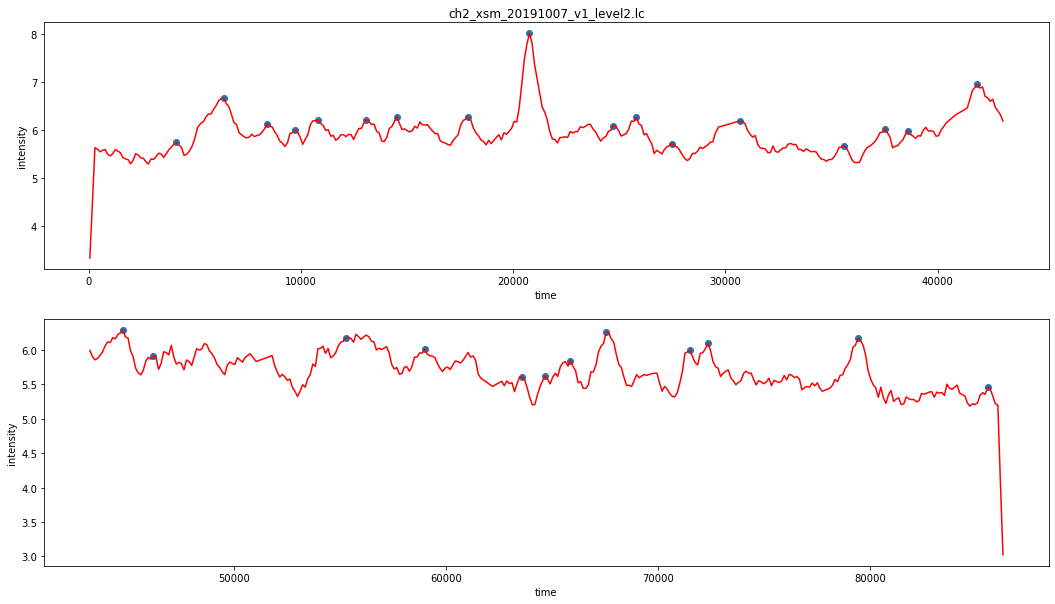

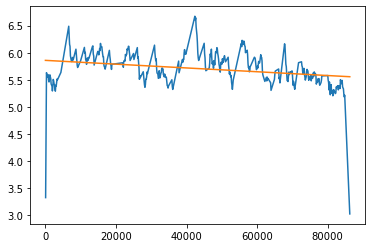

29


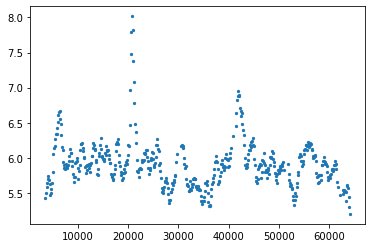

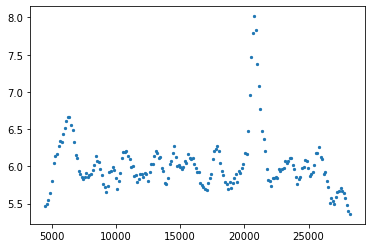

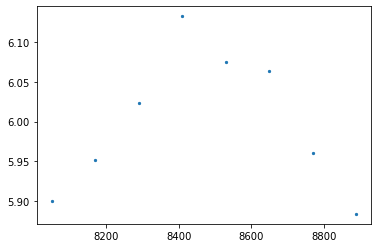

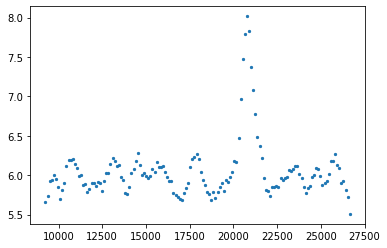

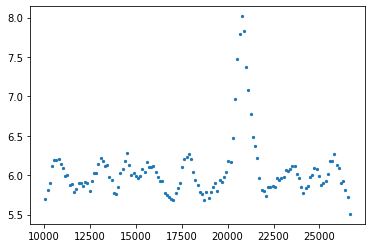

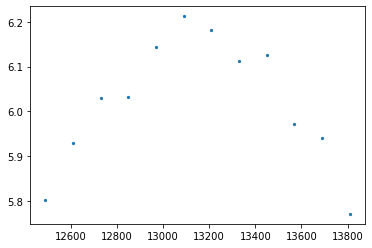

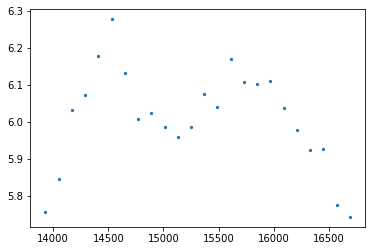

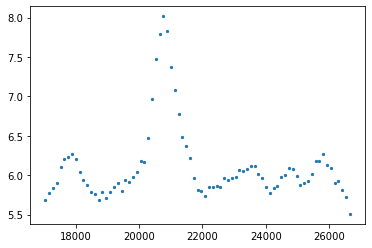

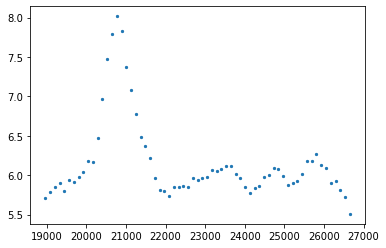

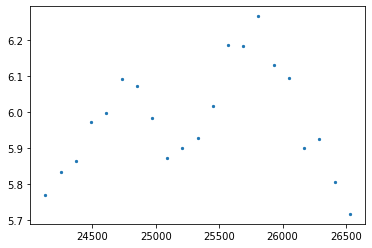

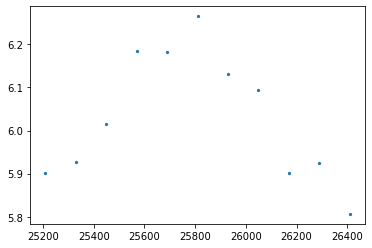

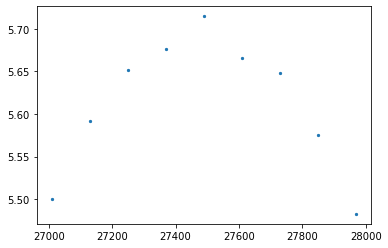

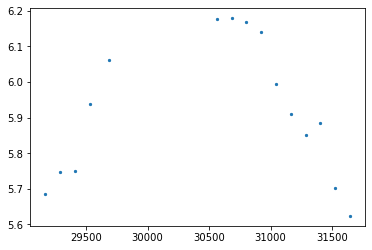

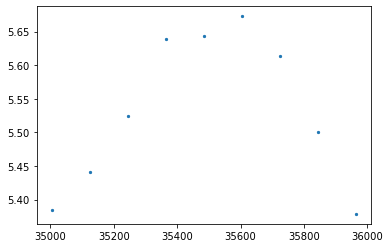

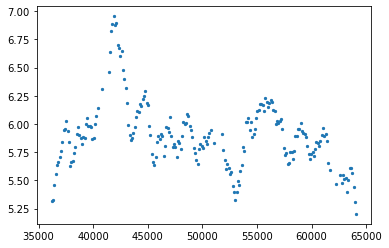

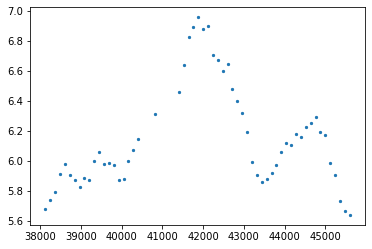

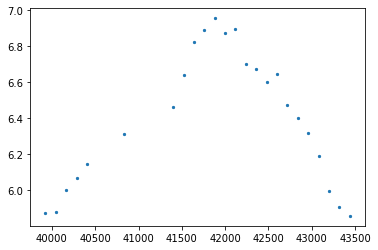

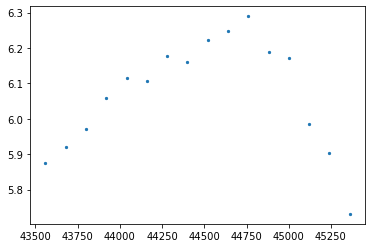

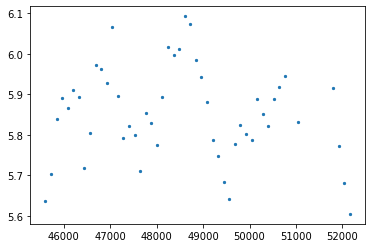

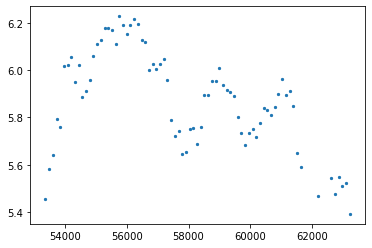

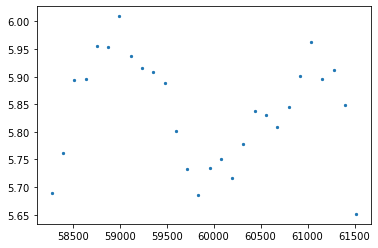

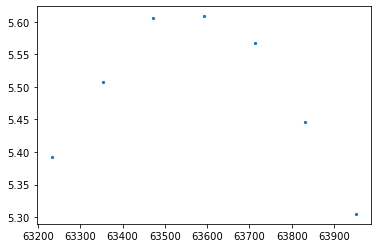

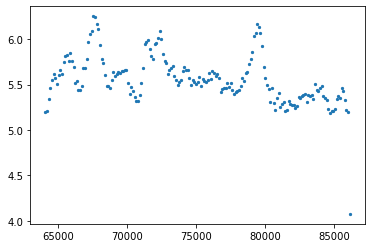

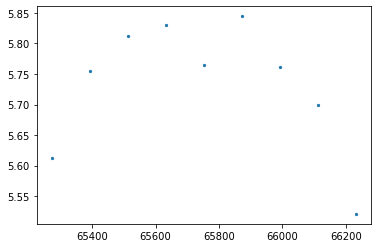

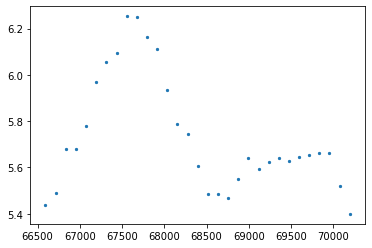

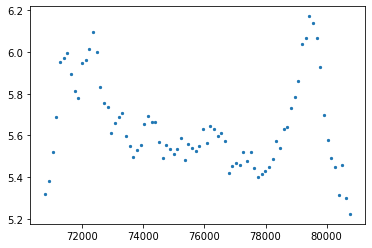

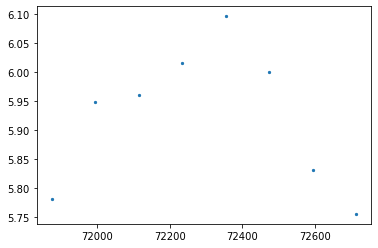

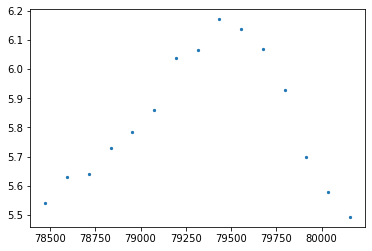

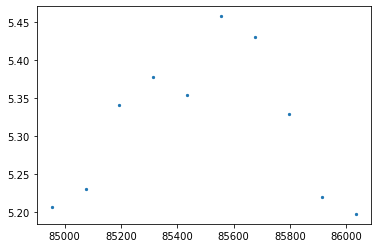

29
mean 5.2022450826911575
std 0.4592649990045038
median 5.107572866678238
max 7.2001398535569505
increment 2.0925669868787127


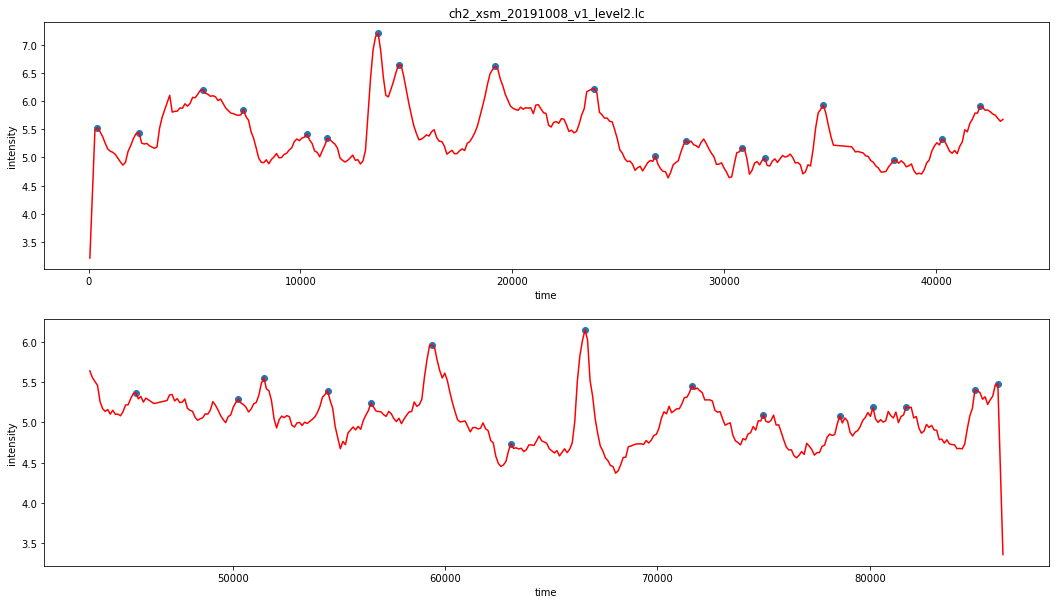

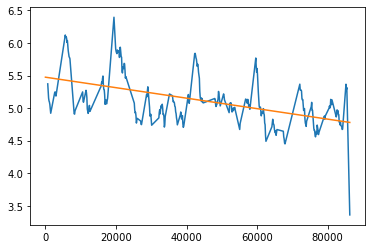

33


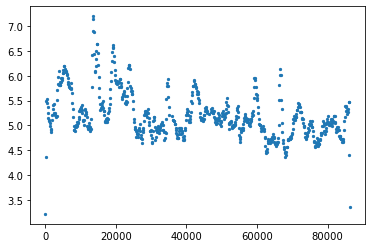

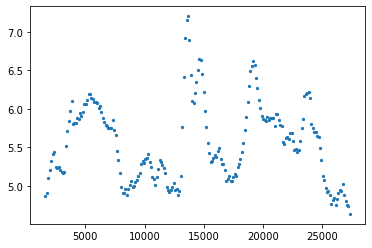

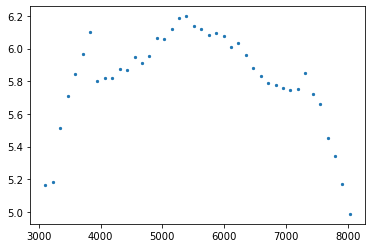

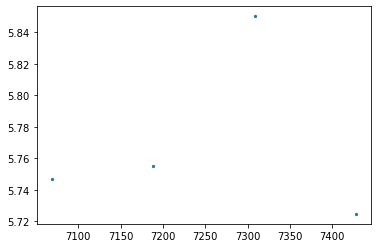

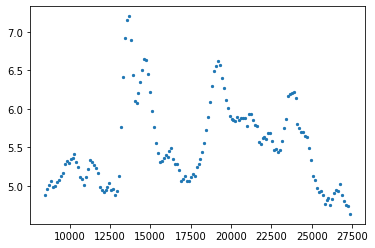

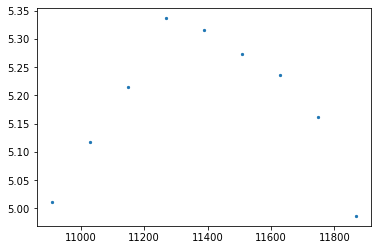

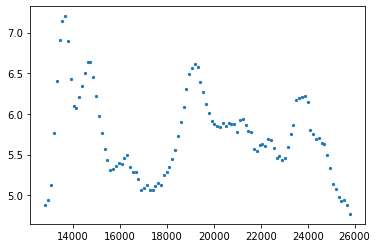

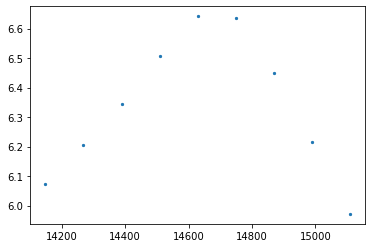

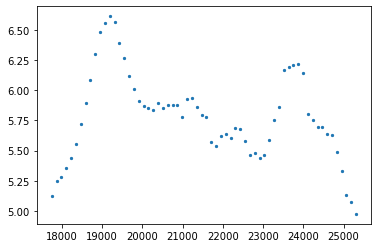

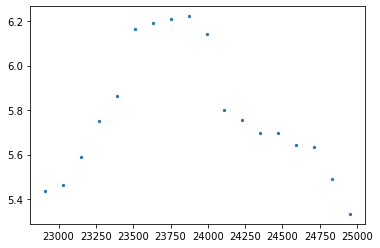

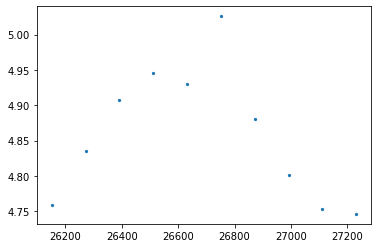

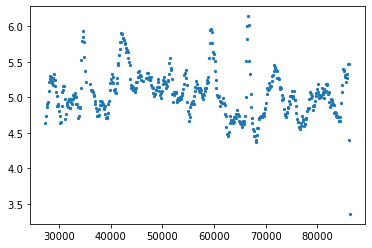

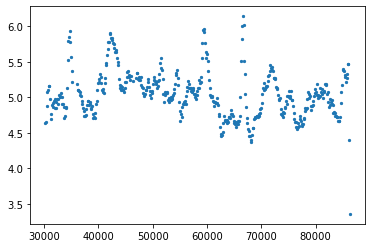

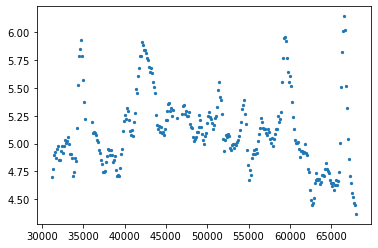

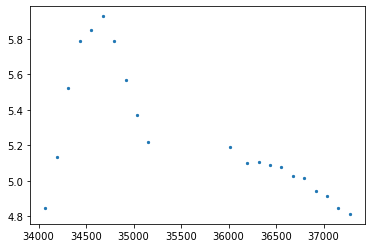

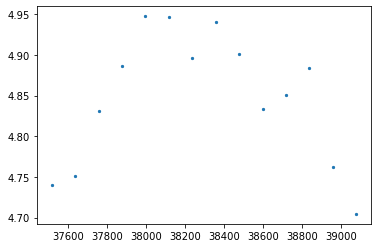

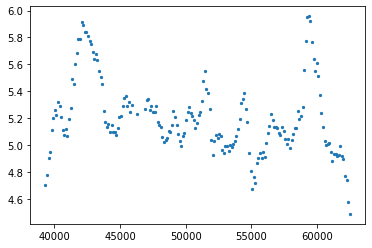

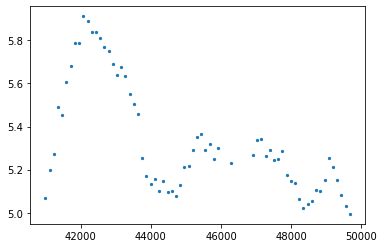

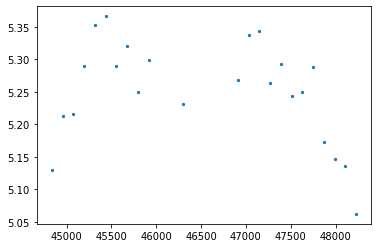

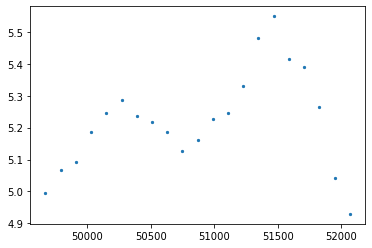

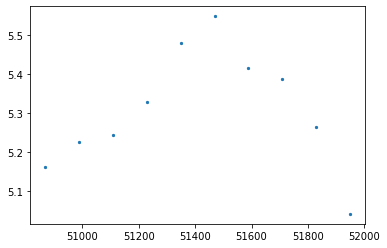

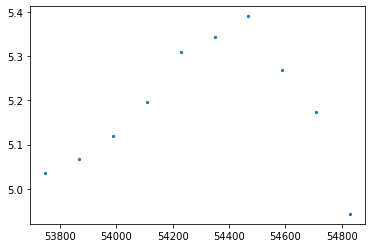

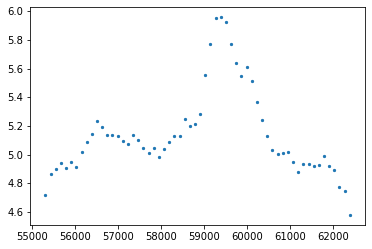

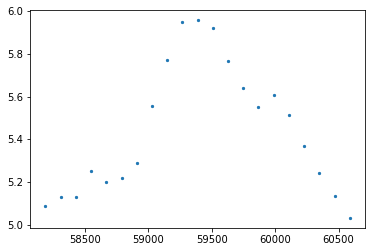

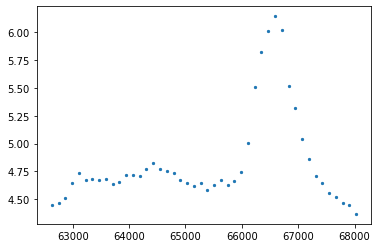

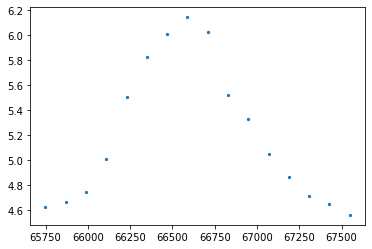

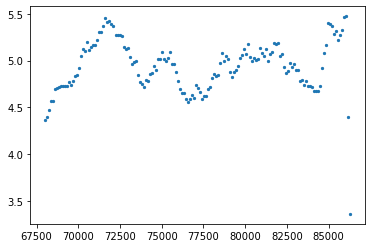

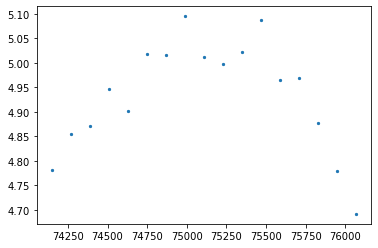

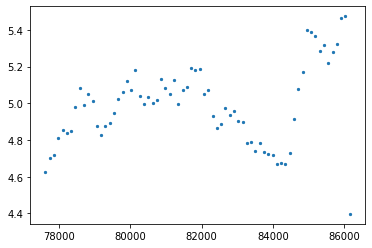

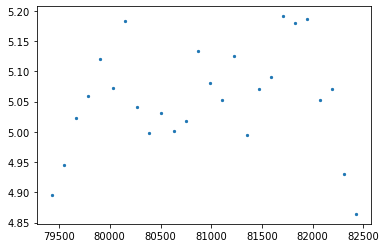

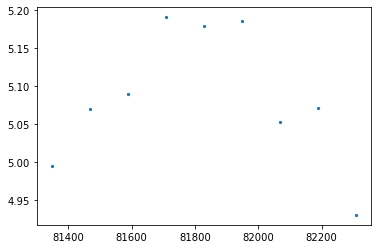

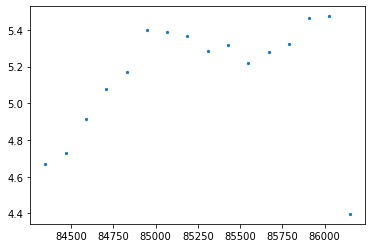

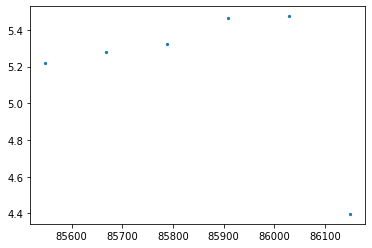

33
mean 5.076236441281182
std 0.7070706180126948
median 4.862522561351458
max 8.26532027065754
increment 3.402797709306082


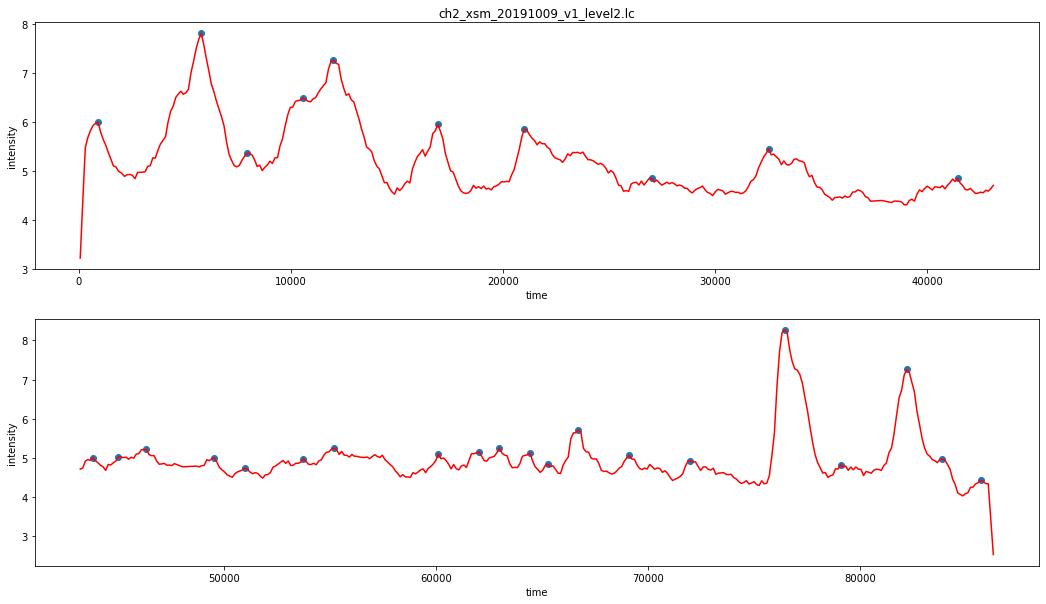

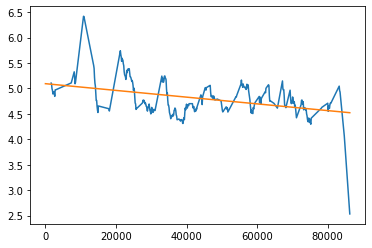

30


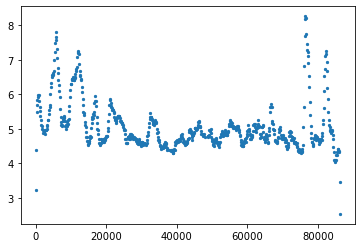

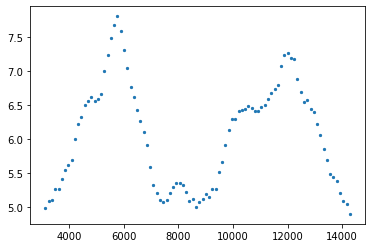

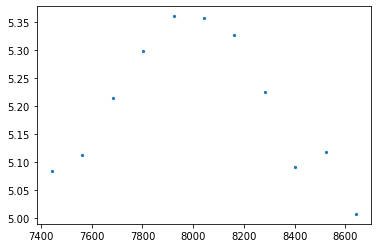

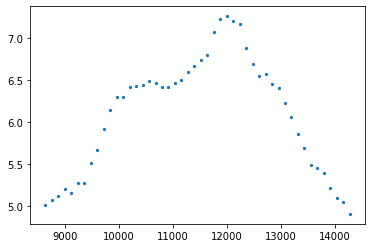

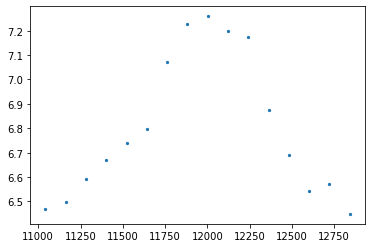

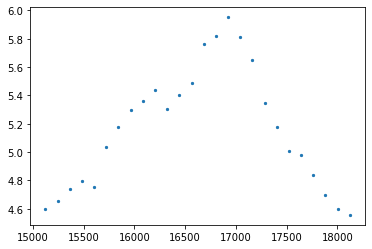

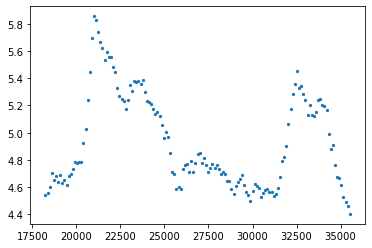

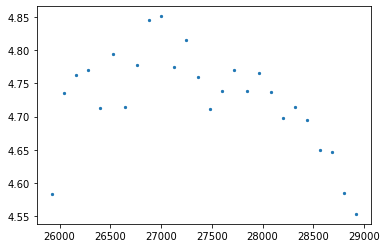

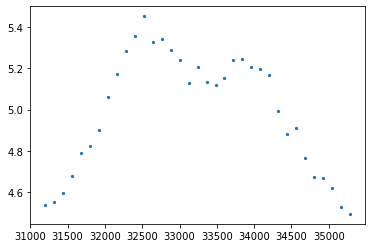

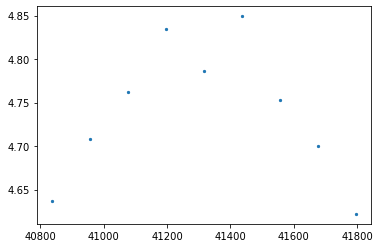

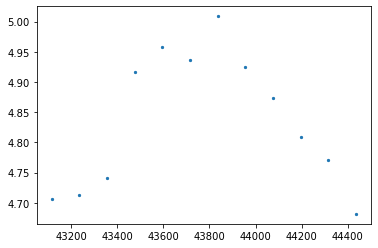

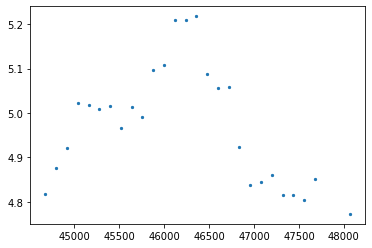

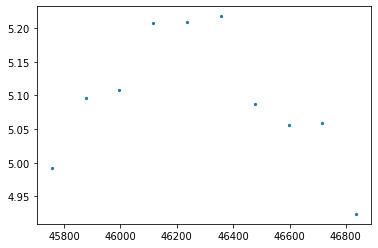

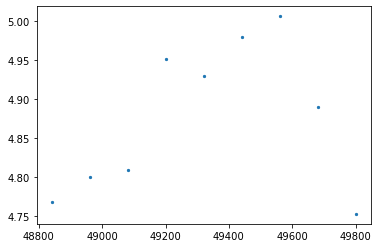

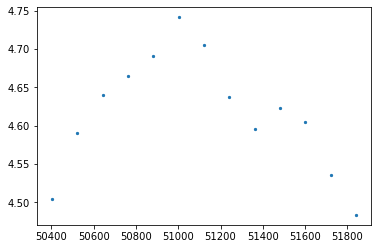

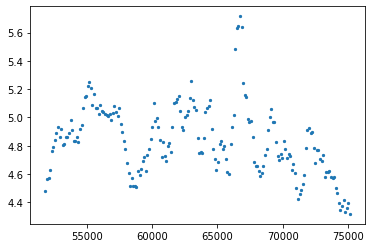

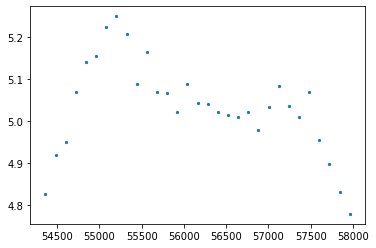

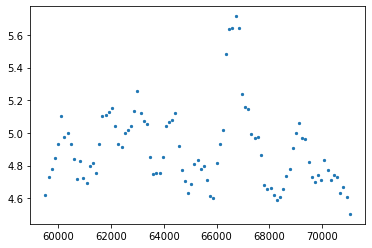

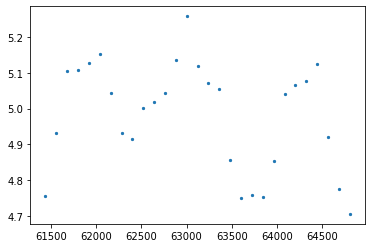

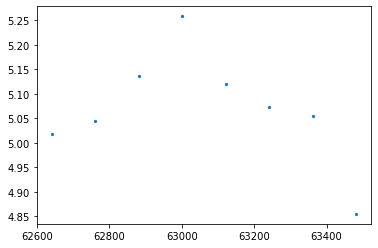

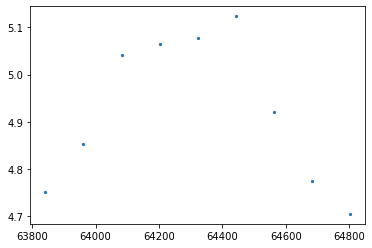

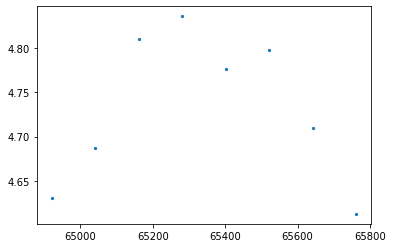

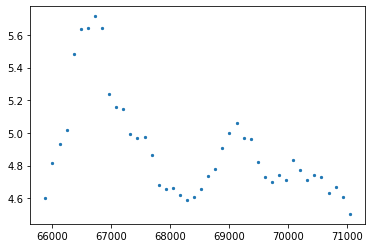

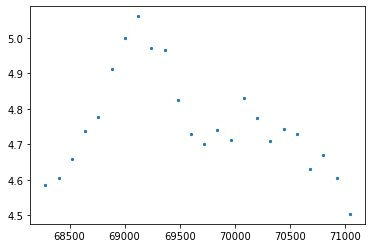

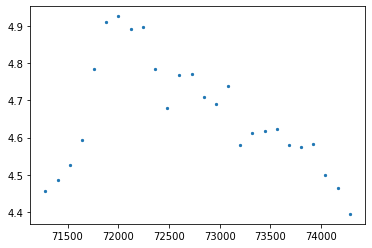

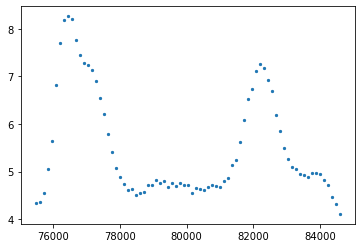

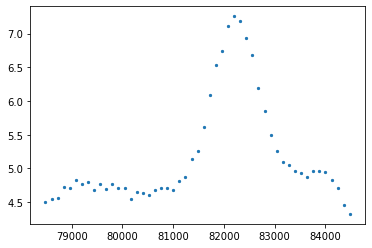

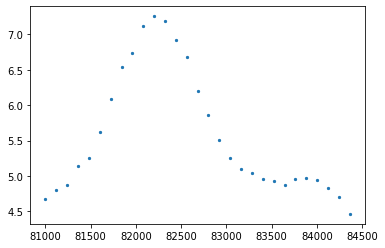

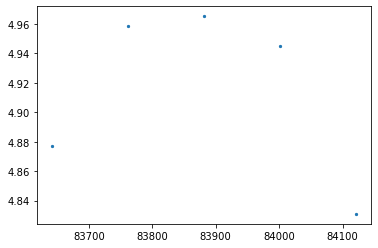

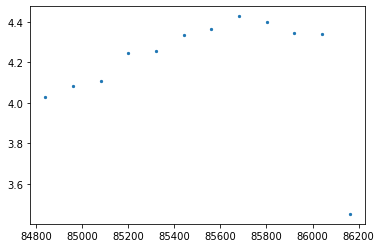

30


In [43]:
%matplotlib inline

def line(x,m,c):
    return m*x + c


for i in range(1,10):
    s = 'ch2_xsm_2019100' + str(i) + '_v1_level2.lc'
    
    dat = prepare_data(s)
    fl_marks, time, intensity = display_data(dat)#preliminary flare_marks are returned
    data_len = len(time)
    #fl_marks_broken = split_flare_marks(n,fl_marks,time[-1])
    #print(fl_marks_broken)

    i_new,t_new = remove_flares(fl_marks, time, intensity) #flareless backround returned
    #i_new = shrink_std(i_new)
    popt, pcov = curve_fit(line, t_new, i_new)

    m = popt[0]
    c = popt[1]
    plt.plot(t_new, i_new)
    arr = np.linspace(0,time[-1],200)
    y1 = []
    for i in arr:
        y1.append(line(i,m,c))
    plt.plot(arr,y1)
    plt.show()


    flare_starts = np.zeros(len(fl_marks))
    for i in range(len(fl_marks)):
        flare_starts[i] = fl_marks[i][0]

    #print(flare_starts)
    print(len(flare_starts))


    flares_t = []
    flares_i = []
    for i in range(0,len(time)):
        if time[i] in flare_starts:
            l_t = []
            l_i = []
            #start = time[i]
            started = True
            for j in range(len(time)-i):
                l_t.append(time[i+j])
                l_i.append(intensity[i+j])
                if intensity[i+j] -  intensity[i] < line(time[i+j],m,c) - line(time[i],m,c):
                    started = False
                    flares_t.append(l_t)
                    flares_i.append(l_i)
                    break
            if started:
                started = False
                flares_t.append(l_t)
                flares_i.append(l_i)

    for i in range(len(flares_t)):
        plt.scatter(flares_t[i], flares_i[i], s = 5)
        plt.show()
    print(len(flares_t))
    #print(i_new)    
